# 📊 ANÁLISIS EXPLORATORIO DE DATOS (EDA) - Versión 8
## TFM: Índice Sintético de Digitalización Educativa (ISDE)
### Máster en Análisis y Visualización de Datos Masivos - UNIR

---

**Autores:** José Miguel Martínez Martín & Rocío Noriega Bustelo  
**Fecha:** Enero 2026

---

| Sección | Dataset | Dimensiones ISDE |
|---------|---------|------------------|
| 2 | TALIS 2024 | D2, D3 |
| 3 | Eurydice 2023 | D3, D4 |
| 4 | Eurostat/DESI 2024 | D1, D2, D3, D4, D5 |
| 5 | UNESCO UIS | D1 |
| 6 | Gráfico Radar comparativo | Todas |
| 7 | Resumen y conclusiones | - |

**Cambios v8:**
- Rutas corregidas a archivos `*_DIMENSIONES.xlsx`
- **Eurostat/DESI incluido** (se había omitido en v7)
- Filtrado por **países presentes en los 4 datasets**
- UNESCO 4.3: Diagrama de barras con **3 países con menor % D1 por año**
- Eurydice 3.3: Eje X ordenado de **mayor a menor** nº políticas

---
# 1. Configuración inicial
---

In [1]:
# ==============================================================================
# 1.1 IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from math import pi

warnings.filterwarnings('ignore')

# Verificar/instalar geopandas
try:
    import geopandas as gpd
    GEOPANDAS_DISPONIBLE = True
    print("✓ geopandas disponible")
except ImportError:
    print("⚠️ Instalando geopandas...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'geopandas', '-q'])
    import geopandas as gpd
    GEOPANDAS_DISPONIBLE = True
    print("✓ geopandas instalado")

print("\n✓ Librerías cargadas correctamente")

✓ geopandas disponible

✓ Librerías cargadas correctamente


🎨 Paleta EU_PASTEL:


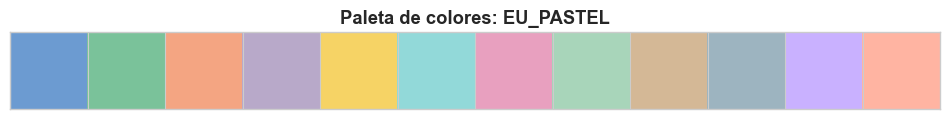

In [2]:
# ==============================================================================
# 1.2 PALETA DE COLORES PROFESIONAL - ESTILO EUROPEO PASTEL
# ==============================================================================

EU_PASTEL = [
    '#6C9BD1',  # Azul europeo suave
    '#7AC29A',  # Verde menta
    '#F4A582',  # Coral suave
    '#B8A9C9',  # Lavanda
    '#F6D365',  # Amarillo dorado suave
    '#92D9D9',  # Turquesa claro
    '#E8A0BF',  # Rosa empolvado
    '#A8D5BA',  # Verde salvia
    '#D4B896',  # Beige cálido
    '#9DB4C0',  # Gris azulado
    '#C9B1FF',  # Lila pastel
    '#FFB4A2',  # Melocotón
]

# Colores específicos para dimensiones ISDE
COLORES_DIMENSIONES = {
    'D1': '#6C9BD1',  # Azul - Infraestructura
    'D2': '#7AC29A',  # Verde - Competencia Docente
    'D3': '#F4A582',  # Coral - Pedagogía
    'D4': '#B8A9C9',  # Lavanda - Liderazgo
    'D5': '#F6D365',  # Amarillo - Equidad
}

NOMBRES_DIMENSIONES = {
    'D1': 'Infraestructura Digital',
    'D2': 'Competencia Digital Docente',
    'D3': 'Pedagogía Digital',
    'D4': 'Liderazgo/Política Institucional',
    'D5': 'Equidad Digital'
}

# Configuración global
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(EU_PASTEL)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'medium'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("🎨 Paleta EU_PASTEL:")
sns.palplot(EU_PASTEL)
plt.title('Paleta de colores: EU_PASTEL', fontweight='bold')
plt.show()

In [3]:
# ==============================================================================
# 1.3 DICCIONARIO COMPLETO DE PAÍSES EUROPEOS
# ==============================================================================

PAISES_EUROPEOS = {
    # Europa Occidental
    'DEU': 'Alemania', 'AUT': 'Austria', 'BEL': 'Bélgica', 'FRA': 'Francia',
    'IRL': 'Irlanda', 'LIE': 'Liechtenstein', 'LUX': 'Luxemburgo', 'MCO': 'Mónaco',
    'NLD': 'Países Bajos', 'CHE': 'Suiza', 'GBR': 'Reino Unido',
    # Europa del Norte
    'DNK': 'Dinamarca', 'EST': 'Estonia', 'FIN': 'Finlandia', 'ISL': 'Islandia',
    'LVA': 'Letonia', 'LTU': 'Lituania', 'NOR': 'Noruega', 'SWE': 'Suecia',
    # Europa del Sur
    'ALB': 'Albania', 'AND': 'Andorra', 'ESP': 'España', 'GRC': 'Grecia',
    'ITA': 'Italia', 'MLT': 'Malta', 'PRT': 'Portugal', 'SMR': 'San Marino',
    'SVN': 'Eslovenia', 'HRV': 'Croacia', 'CYP': 'Chipre', 'MNE': 'Montenegro',
    'MKD': 'Macedonia del Norte', 'SRB': 'Serbia', 'BIH': 'Bosnia y Herzegovina',
    'XKX': 'Kosovo', 'GIB': 'Gibraltar',
    # Europa del Este
    'BGR': 'Bulgaria', 'CZE': 'Chequia', 'HUN': 'Hungría', 'POL': 'Polonia',
    'ROU': 'Rumanía', 'SVK': 'Eslovaquia', 'UKR': 'Ucrania', 'MDA': 'Moldavia',
    'BLR': 'Bielorrusia', 'RUS': 'Rusia',
    # Cáucaso y otros
    'ARM': 'Armenia', 'AZE': 'Azerbaiyán', 'GEO': 'Georgia', 'TUR': 'Turquía', 'KAZ': 'Kazajistán',
}

# Mapeo ISO2 → ISO3
ISO2_TO_ISO3 = {
    'DE': 'DEU', 'AT': 'AUT', 'BE': 'BEL', 'FR': 'FRA', 'IE': 'IRL',
    'LI': 'LIE', 'LU': 'LUX', 'MC': 'MCO', 'NL': 'NLD', 'CH': 'CHE',
    'GB': 'GBR', 'DK': 'DNK', 'EE': 'EST', 'FI': 'FIN', 'IS': 'ISL',
    'LV': 'LVA', 'LT': 'LTU', 'NO': 'NOR', 'SE': 'SWE', 'AL': 'ALB',
    'AD': 'AND', 'ES': 'ESP', 'GR': 'GRC', 'IT': 'ITA', 'MT': 'MLT',
    'PT': 'PRT', 'SM': 'SMR', 'SI': 'SVN', 'HR': 'HRV', 'CY': 'CYP',
    'ME': 'MNE', 'MK': 'MKD', 'RS': 'SRB', 'BA': 'BIH', 'XK': 'XKX',
    'GI': 'GIB', 'BG': 'BGR', 'CZ': 'CZE', 'HU': 'HUN', 'PL': 'POL',
    'RO': 'ROU', 'SK': 'SVK', 'UA': 'UKR', 'MD': 'MDA', 'BY': 'BLR',
    'RU': 'RUS', 'AM': 'ARM', 'AZ': 'AZE', 'GE': 'GEO', 'TR': 'TUR', 'KZ': 'KAZ',
}

ISO3_TO_ISO2 = {v: k for k, v in ISO2_TO_ISO3.items()}
CODIGOS_EUROPEOS_ISO3 = set(PAISES_EUROPEOS.keys())
CODIGOS_EUROPEOS_ISO2 = set(ISO2_TO_ISO3.keys())

def normalizar_a_iso3(codigo):
    """Convierte cualquier código a ISO3."""
    if pd.isna(codigo):
        return None
    codigo = str(codigo).upper().strip()
    if codigo in CODIGOS_EUROPEOS_ISO3:
        return codigo
    if codigo in ISO2_TO_ISO3:
        return ISO2_TO_ISO3[codigo]
    return None

def normalizar_a_iso2(codigo):
    """Convierte cualquier código a ISO2."""
    if pd.isna(codigo):
        return None
    codigo = str(codigo).upper().strip()
    if codigo in CODIGOS_EUROPEOS_ISO2:
        return codigo
    if codigo in ISO3_TO_ISO2:
        return ISO3_TO_ISO2[codigo]
    return None

def obtener_nombre_pais(codigo):
    """Obtiene el nombre del país a partir de su código."""
    iso3 = normalizar_a_iso3(codigo)
    return PAISES_EUROPEOS.get(iso3, str(codigo))

print(f"✓ {len(PAISES_EUROPEOS)} países europeos definidos")

✓ 51 países europeos definidos


In [4]:
# ==============================================================================
# 1.4 RUTAS DE ARCHIVOS Y CARGA DE DATASETS
# ==============================================================================

BASE_PATH = Path(r"C:\Users\Usuario\Desktop\UNIR\TFM\Tablas\Dimensiones")

PATHS = {
    'talis': BASE_PATH / 'TALIS_2024_DIMENSIONES.xlsx',
    'eurydice': BASE_PATH / 'Eurydice_DIMENSIONES.xlsx',
    'eurostat': BASE_PATH / 'EuroStatDESI_DIMENSIONES.csv',
    'unesco': BASE_PATH / 'UNESCO_DIMENSIONES.xlsx'
}

# Verificar archivos
print("📂 Verificación de archivos:")
for name, path in PATHS.items():
    exists = "✓" if path.exists() else "✗"
    print(f"   {exists} {name.upper()}: {path.name}")

📂 Verificación de archivos:
   ✓ TALIS: TALIS_2024_DIMENSIONES.xlsx
   ✓ EURYDICE: Eurydice_DIMENSIONES.xlsx
   ✓ EUROSTAT: EuroStatDESI_DIMENSIONES.csv
   ✓ UNESCO: UNESCO_DIMENSIONES.xlsx


In [5]:
# ==============================================================================
# 1.5 CARGA DE TODOS LOS DATASETS
# ==============================================================================

print("\n" + "="*70)
print("📊 CARGA DE DATASETS")
print("="*70)

# TALIS
talis_raw = pd.read_excel(PATHS['talis'], sheet_name='Datos')
talis_raw['ISO3'] = talis_raw['Pais'].apply(normalizar_a_iso3)
talis_raw['ISO2'] = talis_raw['Pais'].apply(normalizar_a_iso2)
print(f"\n✓ TALIS: {len(talis_raw):,} filas | Países: {talis_raw['ISO3'].nunique()}")

# EURYDICE
eurydice_raw = pd.read_excel(PATHS['eurydice'], sheet_name='Datos')
eurydice_raw['ISO3'] = eurydice_raw['País'].apply(normalizar_a_iso3)
eurydice_raw['ISO2'] = eurydice_raw['País'].apply(normalizar_a_iso2)
print(f"✓ EURYDICE: {len(eurydice_raw):,} filas | Países: {eurydice_raw['ISO3'].nunique()}")

# EUROSTAT/DESI
eurostat_raw = pd.read_csv(PATHS['eurostat'])
eurostat_raw['ISO3'] = eurostat_raw['Pais'].apply(normalizar_a_iso3)
eurostat_raw['ISO2'] = eurostat_raw['Pais'].apply(normalizar_a_iso2)
print(f"✓ EUROSTAT/DESI: {len(eurostat_raw):,} filas | Países: {eurostat_raw['ISO3'].nunique()}")

# UNESCO
unesco_raw = pd.read_excel(PATHS['unesco'], sheet_name='Datos')
unesco_raw['ISO3'] = unesco_raw['Código_ISO'].apply(normalizar_a_iso3)
unesco_raw['ISO2'] = unesco_raw['Código_ISO'].apply(normalizar_a_iso2)
print(f"✓ UNESCO: {len(unesco_raw):,} filas | Países: {unesco_raw['ISO3'].nunique()}")
print("Francia en cada dataset:")
print(f"  TALIS: {talis_raw[talis_raw['Pais'].str.contains('Fr', case=False, na=False)]['Pais'].unique()}")
print(f"  EURYDICE: {eurydice_raw[eurydice_raw['País'].str.contains('Fr', case=False, na=False)]['País'].unique()}")
print(f"  EUROSTAT: {eurostat_raw[eurostat_raw['Pais'].str.contains('Fr', case=False, na=False)]['Pais'].unique()}")
print(f"  UNESCO: {unesco_raw[unesco_raw['Código_ISO'].str.contains('Fr', case=False, na=False)]['Código_ISO'].unique()}")
# Diagnóstico: ¿Qué ISO3 tiene Francia después de normalizar?
print("ISO3 de Francia después de normalizar:")
print(f"  TALIS:    {talis_raw[talis_raw['Pais'].isin(['FRA', 'FR'])]['ISO3'].unique()}")
print(f"  EURYDICE: {eurydice_raw[eurydice_raw['País'].isin(['FRA', 'FR'])]['ISO3'].unique()}")
print(f"  EUROSTAT: {eurostat_raw[eurostat_raw['Pais'].isin(['FRA', 'FR'])]['ISO3'].unique()}")
print(f"  UNESCO:   {unesco_raw[unesco_raw['Código_ISO'].isin(['FRA', 'FR'])]['ISO3'].unique()}")


📊 CARGA DE DATASETS

✓ TALIS: 6,193 filas | Países: 32
✓ EURYDICE: 1,292 filas | Países: 34
✓ EUROSTAT/DESI: 2,483,883 filas | Países: 33
✓ UNESCO: 894 filas | Países: 49
Francia en cada dataset:
  TALIS: ['BFR' 'FRA']
  EURYDICE: ['BEfr' 'FR']
  EUROSTAT: ['FR']
  UNESCO: ['FRA']
ISO3 de Francia después de normalizar:
  TALIS:    ['FRA']
  EURYDICE: ['FRA']
  EUROSTAT: ['FRA']
  UNESCO:   ['FRA']


In [6]:
# ==============================================================================
# 1.6 IDENTIFICACIÓN DE PAÍSES COMUNES A LOS 4 DATASETS
# ==============================================================================

print("\n" + "="*70)
print("🔍 ANÁLISIS DE COBERTURA DE PAÍSES")
print("="*70)

# Obtener países únicos por dataset (solo europeos)
paises_talis = set(talis_raw['ISO3'].dropna().unique())
paises_eurydice = set(eurydice_raw['ISO3'].dropna().unique())
paises_eurostat = set(eurostat_raw['ISO3'].dropna().unique())
paises_unesco = set(unesco_raw['ISO3'].dropna().unique())

print(f"\nPaíses por dataset:")
print(f"   TALIS:    {len(paises_talis)} → {sorted(paises_talis)}")
print(f"   EURYDICE: {len(paises_eurydice)} → {sorted(paises_eurydice)}")
print(f"   EUROSTAT: {len(paises_eurostat)} → {sorted(paises_eurostat)}")
print(f"   UNESCO:   {len(paises_unesco)} → {sorted(paises_unesco)}")

# Intersección: países presentes en los 4 datasets
PAISES_COMUNES_ISO3 = paises_talis & paises_eurydice & paises_eurostat & paises_unesco
PAISES_COMUNES_ISO2 = {normalizar_a_iso2(p) for p in PAISES_COMUNES_ISO3}

print(f"\n" + "="*70)
print(f"✅ PAÍSES COMUNES A LOS 4 DATASETS: {len(PAISES_COMUNES_ISO3)}")
print("="*70)
for iso3 in sorted(PAISES_COMUNES_ISO3):
    iso2 = normalizar_a_iso2(iso3)
    nombre = obtener_nombre_pais(iso3)
    print(f"   • {iso3} / {iso2} → {nombre}")

# Crear matriz de cobertura visual
todos_paises = sorted(paises_talis | paises_eurydice | paises_eurostat | paises_unesco)
cobertura = pd.DataFrame(index=todos_paises)
cobertura['TALIS'] = [1 if p in paises_talis else 0 for p in todos_paises]
cobertura['Eurydice'] = [1 if p in paises_eurydice else 0 for p in todos_paises]
cobertura['Eurostat'] = [1 if p in paises_eurostat else 0 for p in todos_paises]
cobertura['UNESCO'] = [1 if p in paises_unesco else 0 for p in todos_paises]
cobertura['Total'] = cobertura.sum(axis=1)
cobertura.index = [f"{p} ({obtener_nombre_pais(p)})" for p in cobertura.index]
cobertura = cobertura.sort_values('Total', ascending=False)


🔍 ANÁLISIS DE COBERTURA DE PAÍSES

Países por dataset:
   TALIS:    32 → ['ALB', 'AUT', 'AZE', 'BEL', 'BGR', 'CYP', 'CZE', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'HRV', 'HUN', 'ISL', 'ITA', 'KAZ', 'LTU', 'LVA', 'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR']
   EURYDICE: 34 → ['ALB', 'AUT', 'BGR', 'BIH', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'HRV', 'HUN', 'IRL', 'ISL', 'ITA', 'LIE', 'LTU', 'LUX', 'LVA', 'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR']
   EUROSTAT: 33 → ['ALB', 'AUT', 'BEL', 'BGR', 'BIH', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'HRV', 'HUN', 'IRL', 'ITA', 'LTU', 'LUX', 'LVA', 'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR']
   UNESCO:   49 → ['ALB', 'AND', 'ARM', 'AUT', 'AZE', 'BEL', 'BGR', 'BIH', 'BLR', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GIB', 'GRC', 'HRV', 'HUN', 'IRL', 

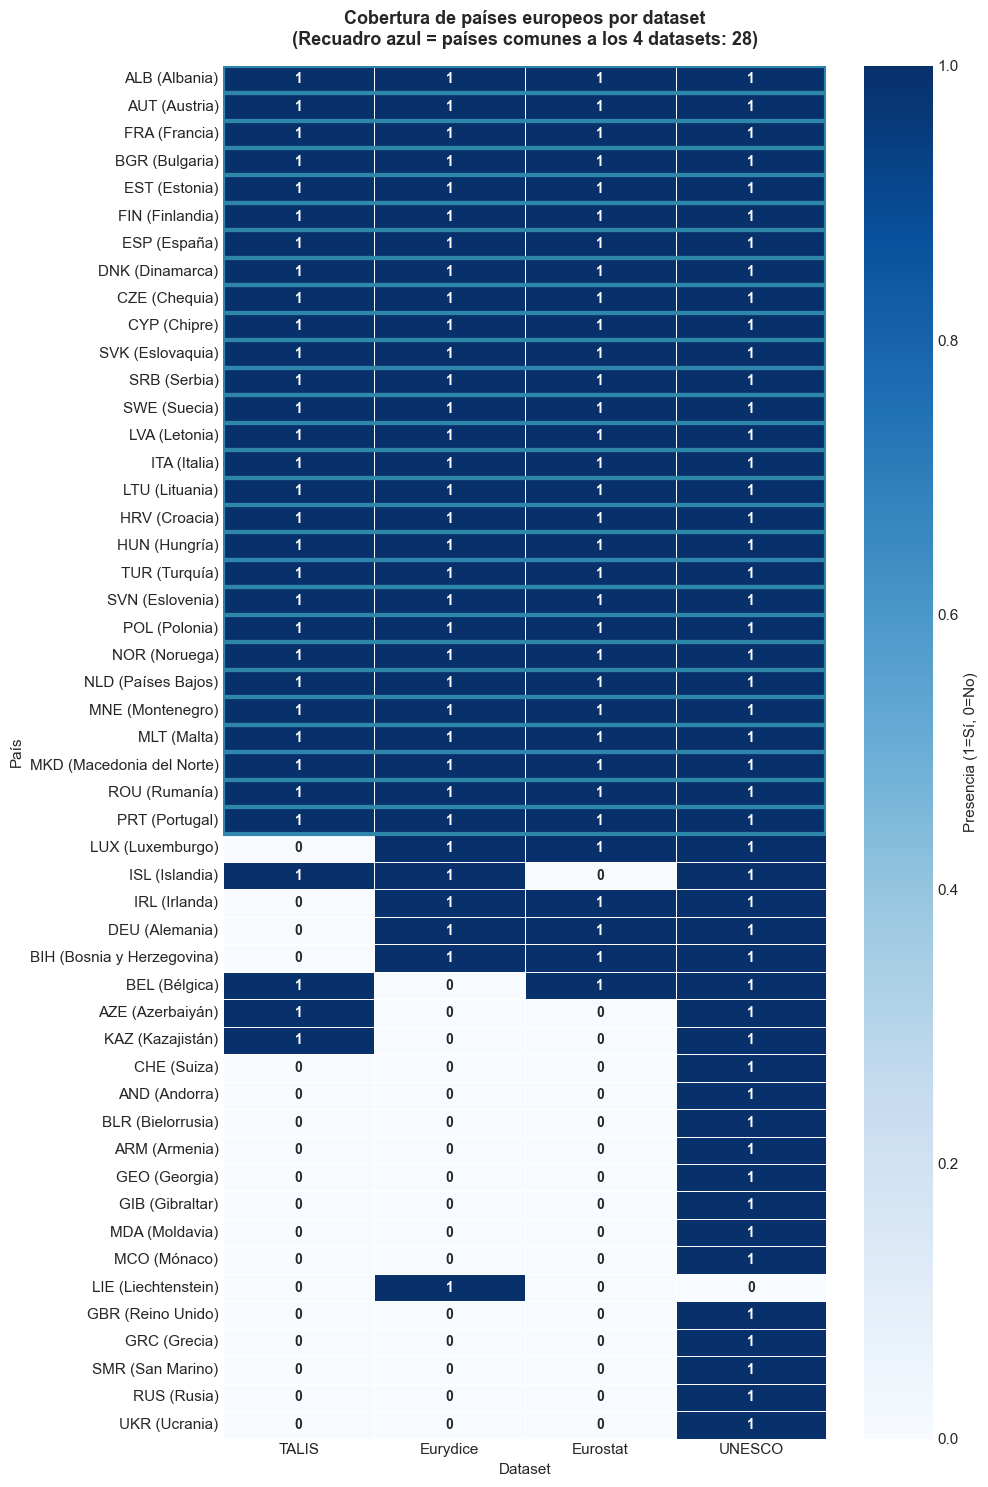

In [7]:
# ==============================================================================
# 1.7 VISUALIZACIÓN: HEATMAP DE COBERTURA
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, max(8, len(cobertura)*0.3)))

# Crear máscara para resaltar países comunes
mask_comunes = cobertura['Total'] == 4

sns.heatmap(cobertura.drop('Total', axis=1), annot=True, cmap='Blues', fmt='d',
            linewidths=0.5, cbar_kws={'label': 'Presencia (1=Sí, 0=No)'},
            annot_kws={'size': 10, 'weight': 'bold'})

# Resaltar filas de países comunes
for i, (idx, row) in enumerate(cobertura.iterrows()):
    if row['Total'] == 4:
        ax.add_patch(plt.Rectangle((0, i), 4, 1, fill=False, edgecolor='#2E86AB', linewidth=3))

ax.set_title(f'Cobertura de países europeos por dataset\n(Recuadro azul = países comunes a los 4 datasets: {len(PAISES_COMUNES_ISO3)})',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Dataset', fontsize=11)
ax.set_ylabel('País', fontsize=11)

plt.tight_layout()
plt.show()

In [8]:
# ==============================================================================
# 1.8 FILTRAR DATASETS PARA USAR SOLO PAÍSES COMUNES
# ==============================================================================

print("\n" + "="*70)
print("🔧 FILTRADO DE DATASETS (SOLO PAÍSES COMUNES)")
print("="*70)

# Filtrar cada dataset
talis = talis_raw[talis_raw['ISO3'].isin(PAISES_COMUNES_ISO3)].copy()
eurydice = eurydice_raw[eurydice_raw['ISO3'].isin(PAISES_COMUNES_ISO3)].copy()
eurostat = eurostat_raw[eurostat_raw['ISO3'].isin(PAISES_COMUNES_ISO3)].copy()
unesco = unesco_raw[unesco_raw['ISO3'].isin(PAISES_COMUNES_ISO3)].copy()

# Añadir nombres de países
talis['Nombre_Pais'] = talis['ISO3'].apply(obtener_nombre_pais)
eurydice['Nombre_Pais'] = eurydice['ISO3'].apply(obtener_nombre_pais)
eurostat['Nombre_Pais'] = eurostat['ISO3'].apply(obtener_nombre_pais)
unesco['Nombre_Pais'] = unesco['ISO3'].apply(obtener_nombre_pais)

print(f"\nRegistros después del filtrado:")
print(f"   TALIS:    {len(talis_raw):,} → {len(talis):,} ({len(talis)/len(talis_raw)*100:.1f}%)")
print(f"   EURYDICE: {len(eurydice_raw):,} → {len(eurydice):,} ({len(eurydice)/len(eurydice_raw)*100:.1f}%)")
print(f"   EUROSTAT: {len(eurostat_raw):,} → {len(eurostat):,} ({len(eurostat)/len(eurostat_raw)*100:.1f}%)")
print(f"   UNESCO:   {len(unesco_raw):,} → {len(unesco):,} ({len(unesco)/len(unesco_raw)*100:.1f}%)")

print(f"\n✅ Análisis EDA se realizará sobre {len(PAISES_COMUNES_ISO3)} países europeos comunes")


🔧 FILTRADO DE DATASETS (SOLO PAÍSES COMUNES)

Registros después del filtrado:
   TALIS:    6,193 → 3,465 (56.0%)
   EURYDICE: 1,292 → 952 (73.7%)
   EUROSTAT: 2,483,883 → 1,924,459 (77.5%)
   UNESCO:   894 → 444 (49.7%)

✅ Análisis EDA se realizará sobre 28 países europeos comunes


In [9]:
# ==============================================================================
# 1.9 CLASIFICACIÓN DE RESPUESTAS POSITIVAS (TALIS)
# ==============================================================================

RESPUESTAS_POSITIVAS_TALIS = [
    'Sí mixta', 'Sí presencial', 'Sí virtual online',
    'Ocasionalmente', 'Siempre', 'Frecuentemente',
    'Bastante', 'En cierta medida', 'Mucho',
    'De acuerdo', 'Muy de acuerdo'
]

def es_respuesta_positiva_talis(valor):
    if pd.isna(valor):
        return False
    return str(valor).strip() in RESPUESTAS_POSITIVAS_TALIS

print("📋 Respuestas POSITIVAS TALIS:")
for r in RESPUESTAS_POSITIVAS_TALIS:
    print(f"   ✓ {r}")

📋 Respuestas POSITIVAS TALIS:
   ✓ Sí mixta
   ✓ Sí presencial
   ✓ Sí virtual online
   ✓ Ocasionalmente
   ✓ Siempre
   ✓ Frecuentemente
   ✓ Bastante
   ✓ En cierta medida
   ✓ Mucho
   ✓ De acuerdo
   ✓ Muy de acuerdo


---
# 2. EDA - TALIS 2024
**Fuente:** OCDE | **Dimensiones ISDE:** D2 (Competencia Docente), D3 (Pedagogía)

---

In [10]:
# ==============================================================================
# 2.1 RESUMEN DE DATOS TALIS
# ==============================================================================

print("="*70)
print("📊 TALIS 2024 - RESUMEN")
print("="*70)
print(f"\nFilas: {len(talis):,}")
print(f"Países: {sorted(talis['Nombre_Pais'].unique())}")
print(f"Dimensiones ISDE: {talis['Dimension_ISDE'].unique().tolist()}")
print(f"Preguntas únicas: {talis['Pregunta'].nunique()}")

print("\n📋 Valores de respuesta:")
for v in talis['Valor'].dropna().unique():
    es_pos = "✓" if es_respuesta_positiva_talis(v) else "✗"
    count = len(talis[talis['Valor'] == v])
    print(f"   {es_pos} '{v}' ({count})")

📊 TALIS 2024 - RESUMEN

Filas: 3,465
Países: ['Albania', 'Austria', 'Bulgaria', 'Chequia', 'Chipre', 'Croacia', 'Dinamarca', 'Eslovaquia', 'Eslovenia', 'España', 'Estonia', 'Finlandia', 'Francia', 'Hungría', 'Italia', 'Letonia', 'Lituania', 'Macedonia del Norte', 'Malta', 'Montenegro', 'Noruega', 'Países Bajos', 'Polonia', 'Portugal', 'Rumanía', 'Serbia', 'Suecia', 'Turquía']
Dimensiones ISDE: ['D2', 'D3']
Preguntas únicas: 8

📋 Valores de respuesta:
   ✗ 'No' (363)
   ✓ 'Sí mixta' (279)
   ✓ 'Sí presencial' (279)
   ✓ 'Sí virtual online' (279)
   ✓ 'Frecuentemente' (140)
   ✗ 'Nunca o casi nunca' (140)
   ✓ 'Ocasionalmente' (140)
   ✓ 'Siempre' (140)
   ✓ 'Bastante' (168)
   ✓ 'En cierta medida' (168)
   ✓ 'Mucho' (168)
   ✗ 'Nada' (168)
   ✓ 'De acuerdo' (56)
   ✗ 'En desacuerdo' (56)
   ✓ 'Muy de acuerdo' (56)
   ✗ 'Muy en desacuerdo' (56)
   ✗ 'Sí' (84)


In [11]:
# ==============================================================================
# 2.2 CÁLCULO DE % RESPUESTAS POSITIVAS POR DIMENSIÓN Y PAÍS
# ==============================================================================

talis['Es_Positiva'] = talis['Valor'].apply(es_respuesta_positiva_talis)

# Filtrar positivas y calcular media de porcentajes
positivas_df = talis[talis['Es_Positiva'] == True].copy()
talis_dim_pais = positivas_df.groupby(['ISO3', 'Nombre_Pais', 'Dimension_ISDE', 'Dimension_Nombre'])['Porcentaje'].mean().reset_index()
talis_dim_pais.columns = ['ISO3', 'Nombre_Pais', 'Dimension', 'Dimension_Nombre', 'Porcentaje_Positivo']

print("📊 % Respuestas positivas por País y Dimensión ISDE:")
pivot_talis = talis_dim_pais.pivot(index='Nombre_Pais', columns='Dimension', values='Porcentaje_Positivo').round(2)
print(pivot_talis.sort_values('D2', ascending=False))

📊 % Respuestas positivas por País y Dimensión ISDE:
Dimension              D2    D3
Nombre_Pais                    
Albania             26.17 36.22
Lituania            24.65 33.82
Letonia             23.62 32.35
Rumanía             23.33 34.99
Polonia             22.96 34.79
Serbia              21.57 34.29
Montenegro          21.51 33.09
Croacia             21.50 31.99
Macedonia del Norte 21.29 32.98
Eslovenia           21.27 32.53
Chequia             21.15 33.53
Turquía             20.90 35.52
Estonia             20.84 30.43
España              20.80 31.80
Chipre              20.44 34.26
Portugal            19.84 33.86
Italia              19.76 32.64
Eslovaquia          19.20 32.81
Bulgaria            19.04 33.95
Hungría             18.99 32.39
Países Bajos        18.96 30.07
Malta               18.94 31.96
Austria             18.73 29.80
Dinamarca           18.22 31.17
Suecia              17.89 25.66
Finlandia           17.84 30.40
Noruega             17.56 27.72
Francia             


📊 TOP 3 RESPUESTAS POSITIVAS DE ALTA FRECUENCIA POR PAÍS

🏳️ Albania:
   69.4% - Ofrece oportunidades para el intercambio colaborativo de ide... (D2)
   68.1% - Se basa en mis conocimientos previos... (D2)
   66.2% - Adapta sus métodos de enseñanza a las necesidades de los alu... (D3)

🏳️ Austria:
   54.7% - El uso de recursos y herramientas digitales ayuda a los estu... (D3)
   50.9% - Cursos/seminarios/talleres... (D2)
   50.8% - Impacto positivo del desarrollo profesional... (D2)

🏳️ Bulgaria:
   61.2% - El uso de recursos y herramientas digitales ayuda a los estu... (D3)
   58.3% - El uso de recursos y herramientas digitales ayuda a mejorar ... (D3)
   55.0% - Adapta sus métodos de enseñanza a las necesidades de los alu... (D3)

🏳️ Chequia:
   69.0% - El uso de recursos y herramientas digitales ayuda a los estu... (D3)
   63.7% - El uso de recursos y herramientas digitales ayuda a mejorar ... (D3)
   63.0% - Reflexiones sobre las observaciones de la lección... (D2)

🏳️ Chipre:
   

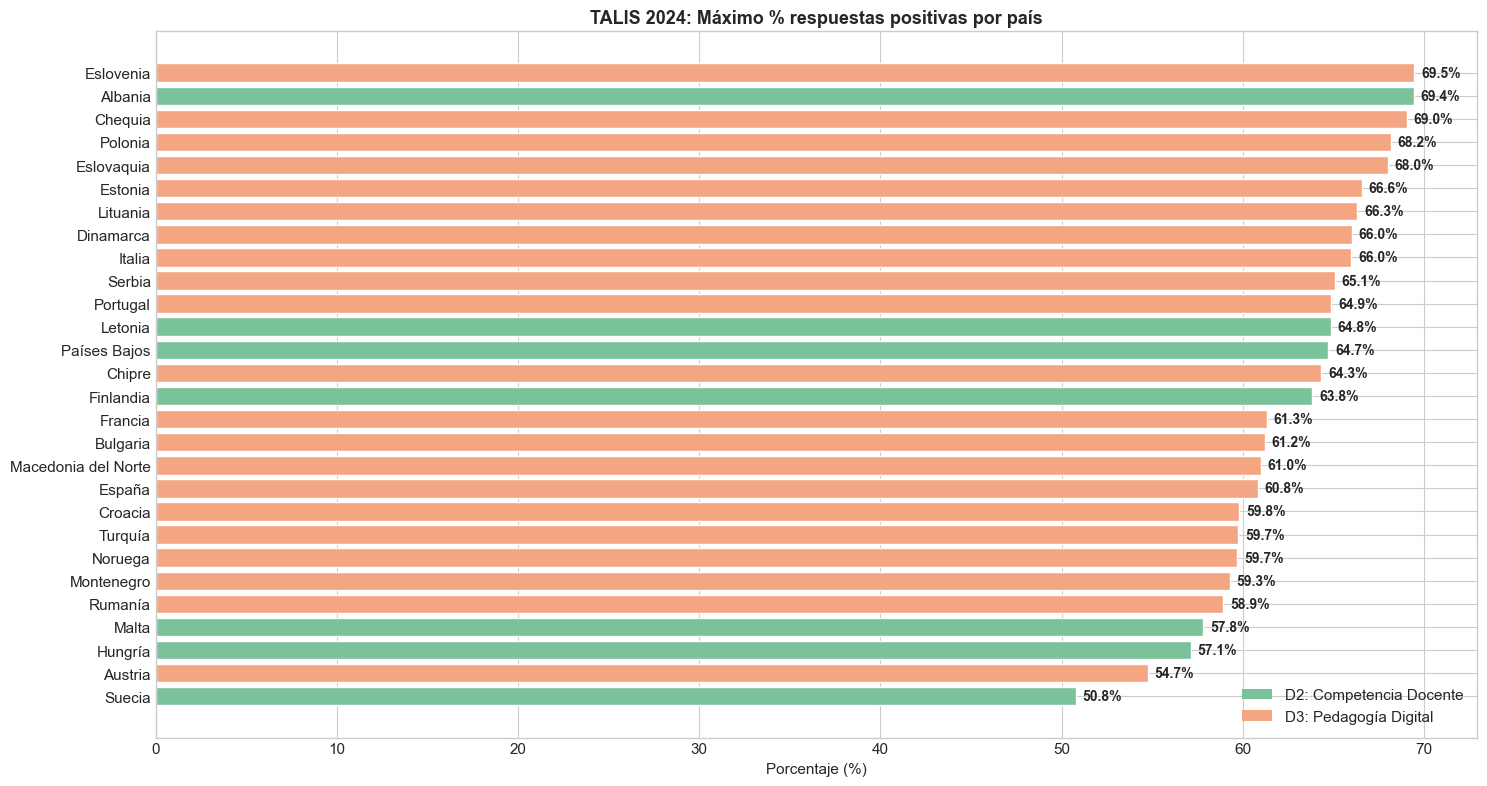

In [12]:
# ==============================================================================
# 2.3 TOP 3 RESPUESTAS DE ALTA FRECUENCIA POR PAÍS
# ==============================================================================

print("\n" + "="*70)
print("📊 TOP 3 RESPUESTAS POSITIVAS DE ALTA FRECUENCIA POR PAÍS")
print("="*70)

top_respuestas = talis[talis['Es_Positiva'] == True].copy()

for pais in sorted(top_respuestas['Nombre_Pais'].unique()):
    df_pais = top_respuestas[top_respuestas['Nombre_Pais'] == pais]
    top3 = df_pais.nlargest(3, 'Porcentaje')
    print(f"\n🏳️ {pais}:")
    for _, row in top3.iterrows():
        print(f"   {row['Porcentaje']:.1f}% - {row['Respuesta'][:60]}... ({row['Dimension_ISDE']})")

# Gráfico de barras con máximo porcentaje por país
fig, ax = plt.subplots(figsize=(15, 8))
max_por_pais = top_respuestas.groupby('Nombre_Pais')['Porcentaje'].max().sort_values(ascending=True)

colors = [COLORES_DIMENSIONES.get(
    top_respuestas[top_respuestas['Nombre_Pais'] == p].nlargest(1, 'Porcentaje')['Dimension_ISDE'].values[0], 
    EU_PASTEL[0]
) for p in max_por_pais.index]

bars = ax.barh(max_por_pais.index, max_por_pais.values, color=colors, edgecolor='white', linewidth=1)
for bar in bars:
    ax.annotate(f'{bar.get_width():.1f}%', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Porcentaje (%)', fontsize=11)
ax.set_title('TALIS 2024: Máximo % respuestas positivas por país', fontsize=13, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORES_DIMENSIONES['D2'], label='D2: Competencia Docente'),
                   Patch(facecolor=COLORES_DIMENSIONES['D3'], label='D3: Pedagogía Digital')]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

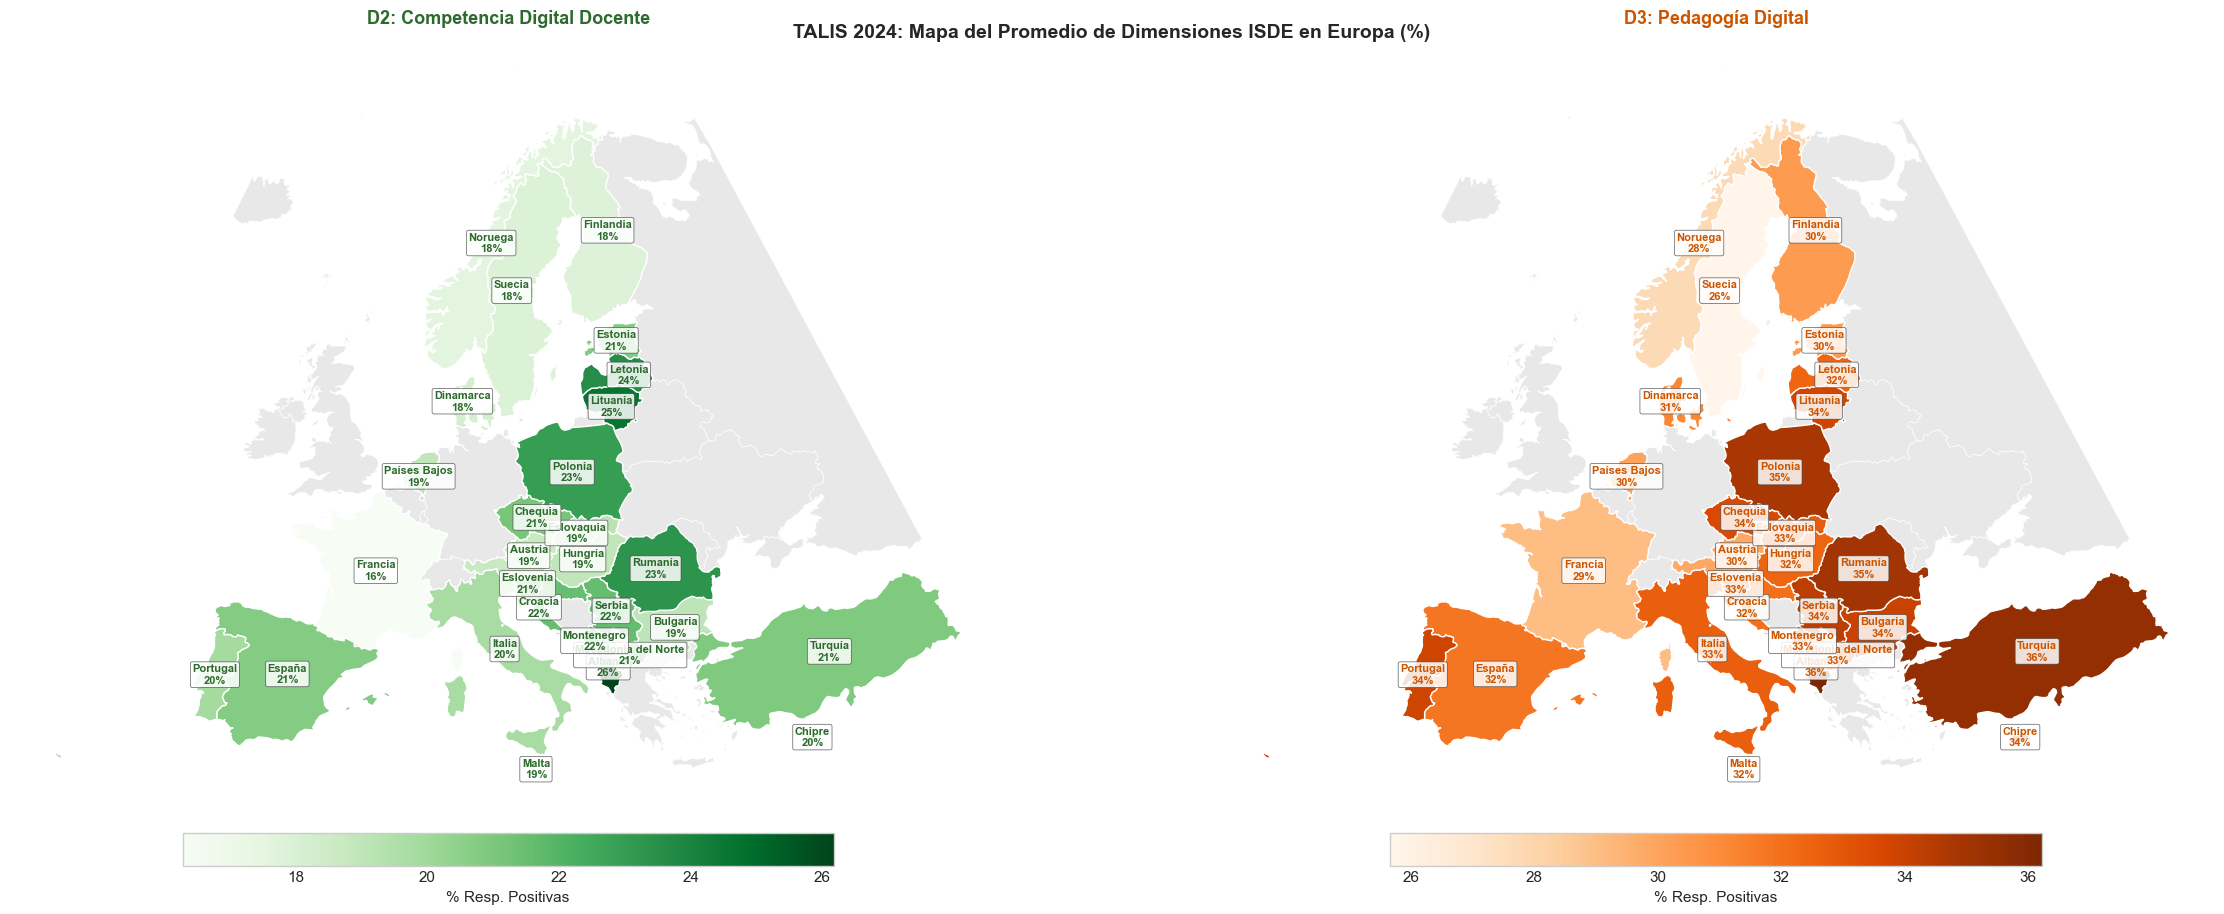

In [42]:
# ==============================================================================
# 2.4 MAPA DE EUROPA CON DIMENSIONES TALIS (incluye Chipre)
# ==============================================================================

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box




# (Opcional) repel automático de textos
try:
    from adjustText import adjust_text
    HAS_ADJUST = True
except ImportError:
    HAS_ADJUST = False


def plot_dim(ax, europa_base, df_dim, dim, cmap, color, titulo):
    # Fondo
    europa_base.plot(ax=ax, color="#E8E8E8", edgecolor="white", linewidth=0.5)

    # Países con dato
    paises = df_dim[df_dim[dim].notna()].copy()
    if paises.empty:
        ax.set_axis_off()
        ax.set_title(titulo, fontsize=13, fontweight="bold", color=color)
        return

    # Coropleta
    paises.plot(
        ax=ax, column=dim, cmap=cmap,
        edgecolor="white", linewidth=1,
        legend=True,
        legend_kwds={
            "label": "% Resp. Positivas",
            "shrink": 0.55,
            "orientation": "horizontal",
            "pad": 0.03
        }
    )

    # Etiquetas
    texts = []
    for _, row in paises.iterrows():
        pt = row.geometry.representative_point()
        label = f"{row['Nombre']}\n{row[dim]:.0f}%"

        t = ax.text(
            pt.x, pt.y, label,
            ha="center", va="center",
            fontsize=8, fontweight="bold", color=color,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="0.25", lw=0.5, alpha=0.85)
        )
        texts.append(t)

    if HAS_ADJUST and texts:
        adjust_text(
            texts, ax=ax,
            expand_text=(1.15, 1.25),
            expand_points=(1.15, 1.25),
            only_move={"texts": "xy"},
            arrowprops=dict(arrowstyle="-", color="0.35", lw=0.6, shrinkA=2, shrinkB=2)
        )

    ax.set_axis_off()
    ax.set_title(titulo, fontsize=13, fontweight="bold", color=color)
    ax.set_aspect("equal")


# --- Carga mapas ---
# --- Carga mapas (mejor resolución) ---
url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(url)
world.columns = world.columns.str.lower()

# Corrección iso_a3 problemáticos (por si acaso)
world.loc[world["name"] == "France", "iso_a3"] = "FRA"
world.loc[world["name"] == "Norway", "iso_a3"] = "NOR"
world.loc[world["name"] == "Kosovo", "iso_a3"] = "XKX"
world.loc[world["name"] == "Cyprus", "iso_a3"] = "CYP"



# --- Tus datos ---
datos_mapa = talis_dim_pais.pivot(
    index="ISO3", columns="Dimension", values="Porcentaje_Positivo"
).reset_index()
datos_mapa["Nombre"] = datos_mapa["ISO3"].apply(obtener_nombre_pais)

# --- Europa base (incluye Turquía aunque sea "Asia") ---
europa = world[(world["continent"] == "Europe") | (world["iso_a3"].isin(["CYP", "TUR"]))].copy()

# Recorte (baja el sur para Malta/Cyprus y deja Turquía europea)
bbox = box(-20, 30, 45, 75)
europa = europa.to_crs(4326).clip(bbox).to_crs(3035)

# --- Debug rápido: qué ISO3 de tus datos NO casan con el mapa ---
iso_datos = set(datos_mapa["ISO3"].dropna().unique())
iso_mapa  = set(europa["iso_a3"].dropna().unique())
faltan = sorted(list(iso_datos - iso_mapa))
if faltan:
    print("ISO3 en tus datos que NO casan con el mapa:", faltan)

# --- Merge por dimensión ---
europa_d2 = europa.merge(
    datos_mapa[["ISO3", "D2", "Nombre"]],
    left_on="iso_a3", right_on="ISO3", how="left"
)
europa_d3 = europa.merge(
    datos_mapa[["ISO3", "D3", "Nombre"]],
    left_on="iso_a3", right_on="ISO3", how="left"
)

# --- Plot final ---
fig, axes = plt.subplots(1, 2, figsize=(24, 9), constrained_layout=True)

plot_dim(axes[0], europa, europa_d2, "D2", "Greens",  "#2d6a2d", "D2: Competencia Digital Docente")
plot_dim(axes[1], europa, europa_d3, "D3", "Oranges", "#cc5500", "D3: Pedagogía Digital")

plt.suptitle(
    "TALIS 2024: Mapa del Promedio de Dimensiones ISDE en Europa (%)",
    fontsize=14, fontweight="bold", y=0.98
)
plt.show()


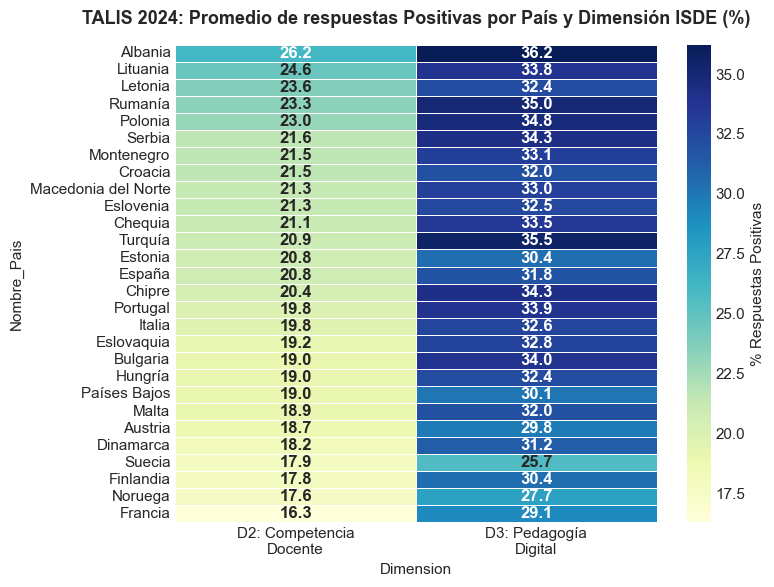


📊 RESUMEN TALIS:
   Mayor D2: Albania (26.2%)
   Mayor D3: Albania (36.2%)


In [35]:
# ==============================================================================
# 2.5 HEATMAP: DIMENSIONES VS PAÍSES (TALIS)
# ==============================================================================

fig, ax = plt.subplots(figsize=(8, 6))
pivot_ordenado = pivot_talis.sort_values('D2', ascending=False)

sns.heatmap(pivot_ordenado, annot=True, fmt='.1f', cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': '% Respuestas Positivas'},
            annot_kws={'size': 12, 'weight': 'bold'})

ax.set_title('TALIS 2024: Promedio de respuestas Positivas por País y Dimensión ISDE (%)',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticklabels(['D2: Competencia\nDocente', 'D3: Pedagogía\nDigital'], rotation=0)
plt.tight_layout()
plt.show()

print(f"\n📊 RESUMEN TALIS:")
print(f"   Mayor D2: {pivot_talis['D2'].idxmax()} ({pivot_talis['D2'].max():.1f}%)")
print(f"   Mayor D3: {pivot_talis['D3'].idxmax()} ({pivot_talis['D3'].max():.1f}%)")

---
# 3. EDA - EURYDICE 2023
**Fuente:** Comisión Europea | **Dimensiones ISDE:** D3 (Pedagogía), D4 (Liderazgo)

---

In [16]:
# ==============================================================================
# 3.1 RESUMEN DE DATOS EURYDICE
# ==============================================================================

print("="*70)
print("📊 EURYDICE 2023 - RESUMEN")
print("="*70)
print(f"\nFilas: {len(eurydice):,}")
print(f"Países: {sorted(eurydice['Nombre_Pais'].unique())}")
print(f"Dimensiones ISDE: {eurydice['Dimension_ISDE'].unique().tolist()}")
print(f"Ítems únicos: {eurydice['Ítem'].nunique()}")
print(f"Valores: {eurydice['Valor'].unique().tolist()}")

# Normalizar valores
eurydice['Valor_Norm'] = eurydice['Valor'].apply(
    lambda x: 'Sí' if str(x).strip().lower() in ['si', 'sí', 'yes'] else 'No'
)

📊 EURYDICE 2023 - RESUMEN

Filas: 952
Países: ['Albania', 'Austria', 'Bulgaria', 'Chequia', 'Chipre', 'Croacia', 'Dinamarca', 'Eslovaquia', 'Eslovenia', 'España', 'Estonia', 'Finlandia', 'Francia', 'Hungría', 'Italia', 'Letonia', 'Lituania', 'Macedonia del Norte', 'Malta', 'Montenegro', 'Noruega', 'Países Bajos', 'Polonia', 'Portugal', 'Rumanía', 'Serbia', 'Suecia', 'Turquía']
Dimensiones ISDE: ['D4', 'D3']
Ítems únicos: 17
Valores: ['No', 'Si']



📋 Distribución de ítems por dimensión ISDE:
Dimension_ISDE  Dimension_Nombre                      
D3              Pedagogía Digital / Uso Pedagógico TIC    448
D4              Liderazgo y Política Institucional        504
dtype: int64


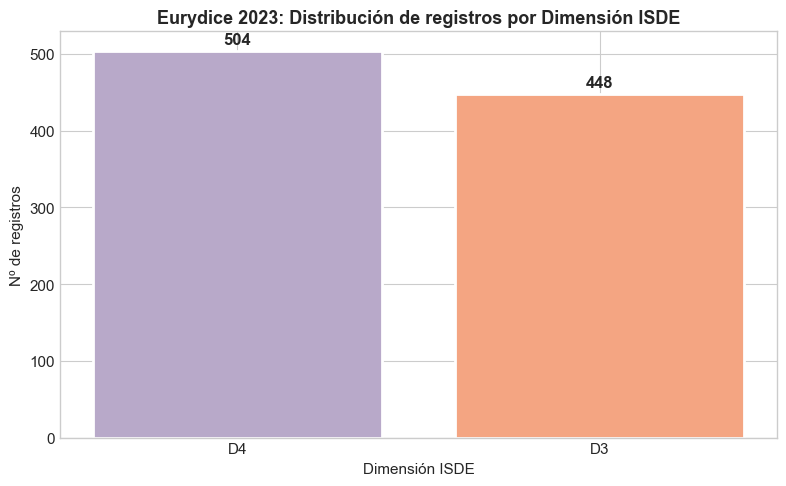

In [17]:
# ==============================================================================
# 3.2 DISTRIBUCIÓN DE ÍTEMS POR DIMENSIÓN
# ==============================================================================

print("\n📋 Distribución de ítems por dimensión ISDE:")
dist_dim = eurydice.groupby(['Dimension_ISDE', 'Dimension_Nombre']).size()
print(dist_dim)

# Gráfico de distribución
fig, ax = plt.subplots(figsize=(8, 5))
dims = eurydice['Dimension_ISDE'].value_counts()
colors = [COLORES_DIMENSIONES.get(d, EU_PASTEL[0]) for d in dims.index]
bars = ax.bar(dims.index, dims.values, color=colors, edgecolor='white', linewidth=2)

for bar in bars:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               xytext=(0, 5), textcoords='offset points', ha='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Dimensión ISDE', fontsize=11)
ax.set_ylabel('Nº de registros', fontsize=11)
ax.set_title('Eurydice 2023: Distribución de registros por Dimensión ISDE', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

📊 Políticas implementadas (Sí) por país y dimensión:
Dimension_ISDE       D3  D4
Nombre_Pais                
Albania               8   2
Austria               6   7
Bulgaria              6   4
Chequia               7   5
Chipre                6   4
Croacia               8   2
Dinamarca             7   2
Eslovaquia            5   3
Eslovenia             8   4
España                8  12
Estonia               6   5
Finlandia             6   2
Francia               8   7
Hungría               7   4
Italia                6  10
Letonia               7   4
Lituania              8   4
Macedonia del Norte   6   6
Malta                 9   6
Montenegro           10   4
Noruega               4   2
Países Bajos          2   4
Polonia               6   2
Portugal              4   6
Rumanía               4   4
Serbia                8   4
Suecia                7   4
Turquía               4   4


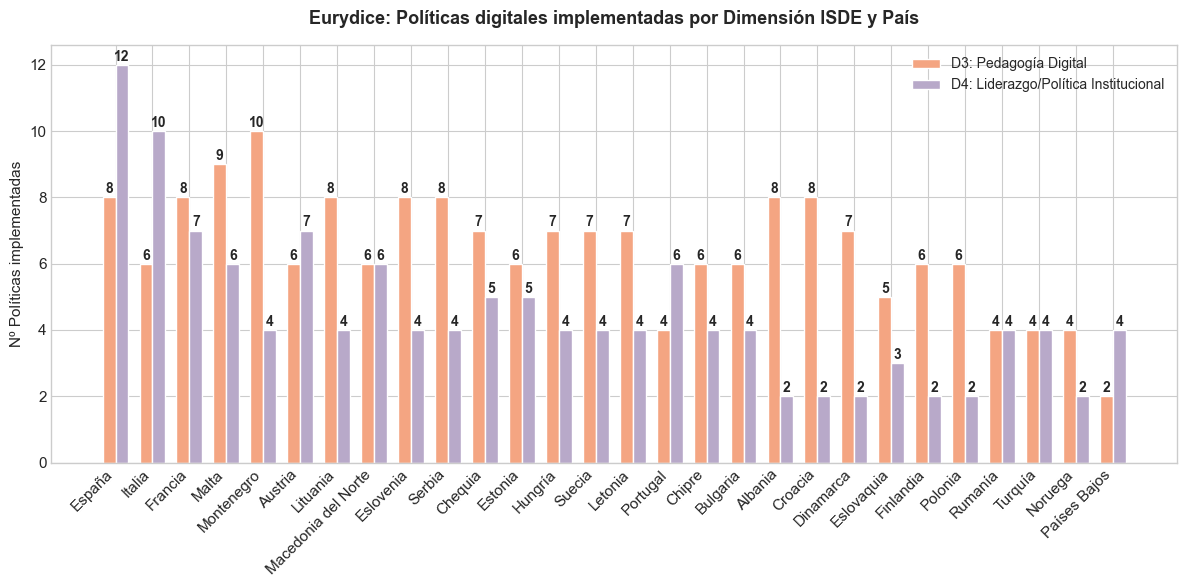

In [43]:
# ==============================================================================
# 3.3 POLÍTICAS POR DIMENSIÓN ISDE Y PAÍS (ORDENADO DE MAYOR A MENOR)
# ==============================================================================

# Contar políticas implementadas (Sí) por dimensión y país
politicas_dim = eurydice[eurydice['Valor_Norm'] == 'Sí'].groupby(['Nombre_Pais', 'Dimension_ISDE']).size().unstack(fill_value=0)

print("📊 Políticas implementadas (Sí) por país y dimensión:")
print(politicas_dim)

if not politicas_dim.empty:
    # Calcular total y ordenar de MAYOR A MENOR
    politicas_dim['Total'] = politicas_dim.sum(axis=1)
    politicas_dim = politicas_dim.sort_values('Total', ascending=False)
    orden_paises = politicas_dim.index.tolist()  # Guardar orden
    politicas_dim = politicas_dim.drop('Total', axis=1)
    
    # Gráfico de barras agrupadas
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(politicas_dim))
    width = 0.35
    dims_presentes = [d for d in ['D3', 'D4'] if d in politicas_dim.columns]
    
    for i, dim in enumerate(dims_presentes):
        offset = (i - len(dims_presentes)/2 + 0.5) * width
        bars = ax.bar(x + offset, politicas_dim[dim], width, 
                      label=f'{dim}: {NOMBRES_DIMENSIONES[dim]}', 
                      color=COLORES_DIMENSIONES[dim], edgecolor='white', linewidth=1)
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                           xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(orden_paises, rotation=45, ha='right')
    ax.set_ylabel('Nº Políticas implementadas', fontsize=11)
    ax.set_title('Eurydice: Políticas digitales implementadas por Dimensión ISDE y País',
                 fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

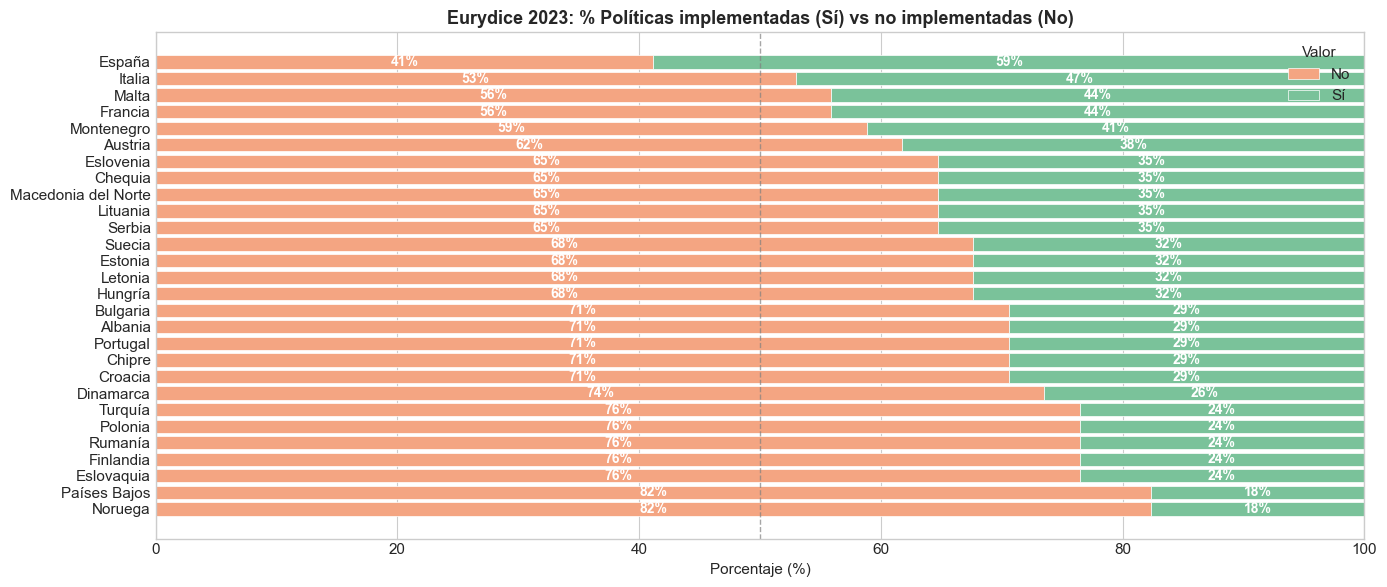

In [19]:
# ==============================================================================
# 3.4 PROPORCIÓN POLÍTICAS IMPLEMENTADAS VS NO IMPLEMENTADAS
# ==============================================================================

prop_pais = eurydice.groupby(['Nombre_Pais', 'Valor_Norm']).size().unstack(fill_value=0)
prop_pais_pct = prop_pais.div(prop_pais.sum(axis=1), axis=0) * 100

if 'Sí' in prop_pais_pct.columns:
    prop_pais_pct = prop_pais_pct.sort_values('Sí', ascending=True)

fig, ax = plt.subplots(figsize=(14, 6))
colors = {'No': '#F4A582', 'Sí': '#7AC29A'}

left = np.zeros(len(prop_pais_pct))
for col in ['No', 'Sí']:
    if col in prop_pais_pct.columns:
        bars = ax.barh(prop_pais_pct.index, prop_pais_pct[col], left=left, 
                       label=col, color=colors.get(col), edgecolor='white', linewidth=0.5)
        for i, (bar, val) in enumerate(zip(bars, prop_pais_pct[col])):
            if val > 5:
                ax.text(left[i] + val/2, bar.get_y() + bar.get_height()/2,
                       f'{val:.0f}%', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        left += prop_pais_pct[col].values

ax.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Porcentaje (%)', fontsize=11)
ax.set_title('Eurydice 2023: % Políticas implementadas (Sí) vs no implementadas (No)', fontsize=13, fontweight='bold')
ax.legend(title='Valor', loc='upper right')
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

---
# 4. EDA - EUROSTAT/DESI 2024
**Fuente:** Eurostat + DESI | **Dimensiones ISDE:** D1, D2, D3, D4, D5

---

In [20]:
# ==============================================================================
# 4.1 RESUMEN DE DATOS EUROSTAT/DESI
# ==============================================================================

print("="*70)
print("📊 EUROSTAT/DESI 2024 - RESUMEN")
print("="*70)
print(f"\nFilas: {len(eurostat):,}")
print(f"Países: {sorted(eurostat['Nombre_Pais'].unique())}")
print(f"Dimensiones ISDE: {sorted(eurostat['Dimension_ISDE'].dropna().unique())}")
print(f"Variables únicas: {eurostat['Variable_Codigo'].nunique()}")
print(f"\nDistribución por dimensión:")
print(eurostat['Dimension_ISDE'].value_counts())

📊 EUROSTAT/DESI 2024 - RESUMEN

Filas: 1,924,459
Países: ['Albania', 'Austria', 'Bulgaria', 'Chequia', 'Chipre', 'Croacia', 'Dinamarca', 'Eslovaquia', 'Eslovenia', 'España', 'Estonia', 'Finlandia', 'Francia', 'Hungría', 'Italia', 'Letonia', 'Lituania', 'Macedonia del Norte', 'Malta', 'Montenegro', 'Noruega', 'Países Bajos', 'Polonia', 'Portugal', 'Rumanía', 'Serbia', 'Suecia', 'Turquía']
Dimensiones ISDE: ['D1', 'D2', 'D3', 'D4', 'D5']
Variables únicas: 242

Distribución por dimensión:
Dimension_ISDE
D1    961202
D2    881805
D5     29684
D4     29684
D3     22084
Name: count, dtype: int64


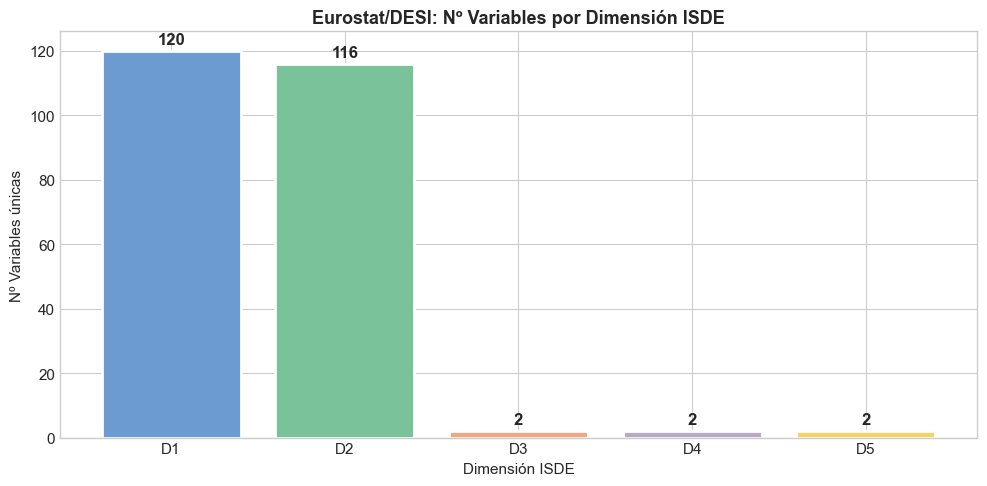

In [21]:
# ==============================================================================
# 4.2 DISTRIBUCIÓN DE VARIABLES POR DIMENSIÓN ISDE
# ==============================================================================

# Variables por dimensión
vars_por_dim = eurostat.groupby('Dimension_ISDE')['Variable_Codigo'].nunique()

fig, ax = plt.subplots(figsize=(10, 5))
colors = [COLORES_DIMENSIONES.get(d, EU_PASTEL[0]) for d in vars_por_dim.index]
bars = ax.bar(vars_por_dim.index, vars_por_dim.values, color=colors, edgecolor='white', linewidth=2)

for bar in bars:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               xytext=(0, 5), textcoords='offset points', ha='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Dimensión ISDE', fontsize=11)
ax.set_ylabel('Nº Variables únicas', fontsize=11)
ax.set_title('Eurostat/DESI: Nº Variables por Dimensión ISDE', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

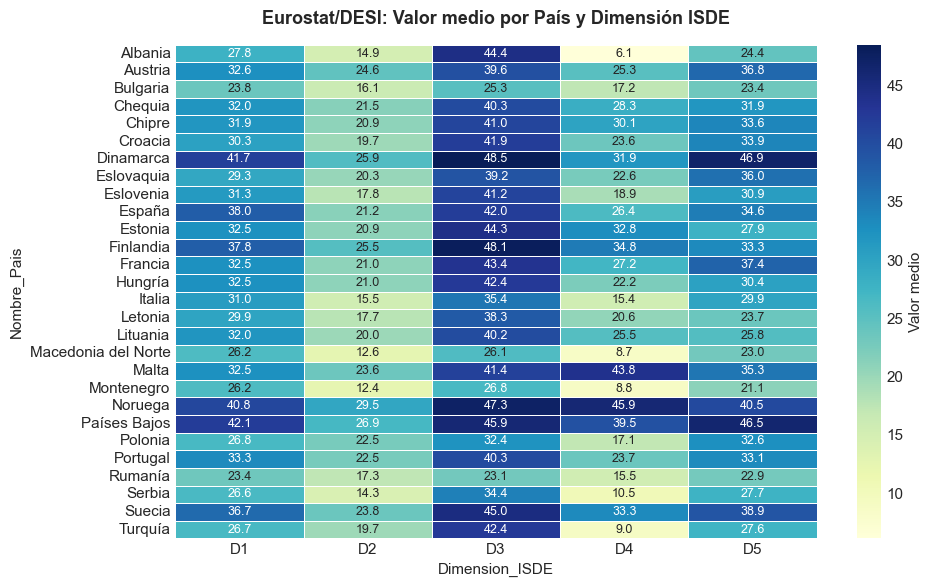

In [22]:
# ==============================================================================
# 4.3 VALOR MEDIO POR DIMENSIÓN Y PAÍS
# ==============================================================================

# Calcular media de valores por país y dimensión
eurostat_dim_pais = eurostat.groupby(['Nombre_Pais', 'Dimension_ISDE'])['Valor'].mean().reset_index()

# Pivot para heatmap
pivot_eurostat = eurostat_dim_pais.pivot(index='Nombre_Pais', columns='Dimension_ISDE', values='Valor')

# Normalizar a escala 0-100 si los valores son proporciones
if pivot_eurostat.max().max() <= 1:
    pivot_eurostat = pivot_eurostat * 100

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_eurostat.round(1), annot=True, fmt='.1f', cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': 'Valor medio'},
            annot_kws={'size': 9})

ax.set_title('Eurostat/DESI: Valor medio por País y Dimensión ISDE', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

In [23]:
# ==============================================================================
# 4.4 TOP 5 VARIABLES MÁS RELEVANTES POR DIMENSIÓN
# ==============================================================================

print("\n📊 TOP 5 VARIABLES POR DIMENSIÓN (mayor variabilidad entre países):")

for dim in sorted(eurostat['Dimension_ISDE'].dropna().unique()):
    df_dim = eurostat[eurostat['Dimension_ISDE'] == dim]
    
    # Calcular coeficiente de variación por variable
    cv_vars = df_dim.groupby('Variable_Descripcion')['Valor'].agg(['mean', 'std'])
    cv_vars['cv'] = cv_vars['std'] / cv_vars['mean']
    cv_vars = cv_vars.dropna().sort_values('cv', ascending=False)
    
    print(f"\n{dim} - {NOMBRES_DIMENSIONES.get(dim, dim)}:")
    for var in cv_vars.head(5).index:
        var_short = var[:70] + '...' if len(var) > 70 else var
        print(f"   • {var_short}")


📊 TOP 5 VARIABLES POR DIMENSIÓN (mayor variabilidad entre países):

D1 - Infraestructura Digital:
   • En los últimos 3 meses, accedí a internet menos de una vez por semana ...
   • Último uso de internet: entre 3 y 12 meses atrás
   • En los últimos 3 meses, accedí a internet al menos una vez por semana ...
   • No sabe si algún miembro del hogar tiene acceso a internet en casa
   • Uso de internet: no solicitó documento oficial ni hizo reclamación - p...

D2 - Competencia Digital Docente:
   • Ordenador de sobremesa antiguo: otra acción
   • Razón para no usar sistemas IoT: preocupaciones sobre seguridad o salu...
   • Portátil o tablet antiguo: otra acción
   • Compras online (3 meses): compra o venta de acciones, bonos, participa...
   • Razón para no usar sistemas IoT: preocupaciones sobre seguridad (ej. q...

D3 - Pedagogía Digital:
   • Alta intensidad de uso de diferentes servicios de e-gobierno
   • Baja intensidad de uso de diferentes servicios de e-gobierno

D4 - Liderazgo/

---
# 5. EDA - UNESCO UIS
**Fuente:** UNESCO Institute for Statistics | **Dimensiones ISDE:** D1 (Infraestructura)

---

In [24]:
# ==============================================================================
# 5.1 RESUMEN DE DATOS UNESCO
# ==============================================================================

print("="*70)
print("📊 UNESCO UIS - RESUMEN")
print("="*70)
print(f"\nFilas: {len(unesco):,}")
print(f"Países: {sorted(unesco['Nombre_Pais'].unique())}")
print(f"Indicadores: {unesco['Indicador'].nunique()} únicos")
print(f"Rango temporal: {unesco['Año'].min()} - {unesco['Año'].max()}")
print(f"Dimensiones ISDE: {unesco['Dimension_ISDE'].unique().tolist()}")
print(f"Tipos de recurso: {unesco['Tipo_Recurso'].unique().tolist()}")

📊 UNESCO UIS - RESUMEN

Filas: 444
Países: ['Albania', 'Austria', 'Bulgaria', 'Chequia', 'Chipre', 'Croacia', 'Dinamarca', 'Eslovaquia', 'Eslovenia', 'España', 'Estonia', 'Finlandia', 'Francia', 'Hungría', 'Italia', 'Letonia', 'Lituania', 'Macedonia del Norte', 'Malta', 'Montenegro', 'Noruega', 'Países Bajos', 'Polonia', 'Portugal', 'Rumanía', 'Serbia', 'Suecia', 'Turquía']
Indicadores: 5 únicos
Rango temporal: 2018 - 2024
Dimensiones ISDE: ['D1']
Tipos de recurso: ['Ordenadores', 'Internet']


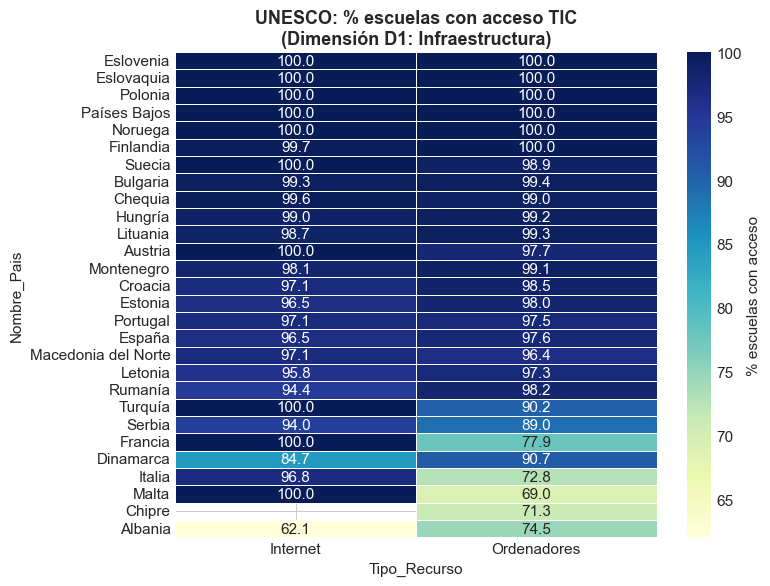

In [25]:
# ==============================================================================
# 5.2 HEATMAP: % ESCUELAS CON ACCESO TIC (ÚLTIMO DATO)
# ==============================================================================

# Obtener último dato por país-tipo_recurso
ultimo_dato = unesco.sort_values('Año').groupby(['Nombre_Pais', 'Tipo_Recurso']).last().reset_index()

# Pivot
pivot_unesco = ultimo_dato.pivot(index='Nombre_Pais', columns='Tipo_Recurso', values='Valor_Porcentaje')
pivot_unesco['Media'] = pivot_unesco.mean(axis=1)
pivot_unesco = pivot_unesco.sort_values('Media', ascending=False).drop('Media', axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(pivot_unesco, annot=True, fmt='.1f', cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': '% escuelas con acceso'},
            annot_kws={'size': 11}, mask=pivot_unesco.isna())

ax.set_title('UNESCO: % escuelas con acceso TIC\n(Dimensión D1: Infraestructura)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

📊 TOP 3 PAÍSES CON MENOR % INFRAESTRUCTURA (D1) POR AÑO:

📅 2018:
   • Albania: 77.9%
   • Macedonia del Norte: 93.5%
   • Hungría: 97.0%

📅 2019:
   • Chipre: 36.1%
   • Italia: 42.9%
   • Francia: 53.7%

📅 2020:
   • Portugal: 97.9%
   • Lituania: 99.6%
   • Chequia: 99.9%

📅 2021:
   • Albania: 71.2%
   • Portugal: 98.2%
   • Lituania: 99.6%

📅 2022:
   • Albania: 68.3%
   • Dinamarca: 87.7%
   • Serbia: 91.5%

📅 2023:
   • Malta: 69.0%
   • Chipre: 71.3%
   • Italia: 72.8%

📅 2024:
   • Eslovaquia: 100.0%


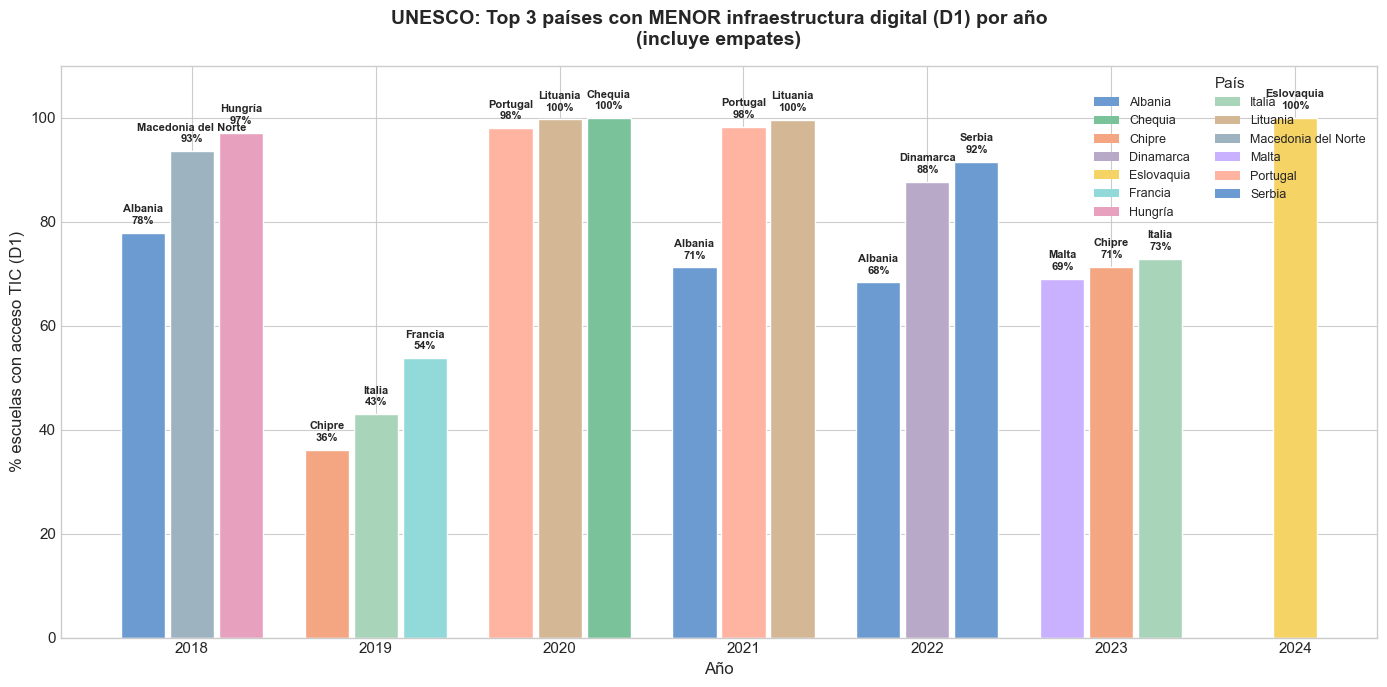

In [26]:
# ==============================================================================
# 5.3 TOP 3 PAÍSES CON MENOR % D1 POR AÑO (DIAGRAMA DE BARRAS)
# ==============================================================================

# Calcular % medio de D1 (Internet + Ordenadores) por país y año
d1_por_anio = unesco.groupby(['Año', 'Nombre_Pais', 'ISO3'])['Valor_Porcentaje'].mean().reset_index()
d1_por_anio.columns = ['Año', 'Nombre_Pais', 'ISO3', 'D1_Porcentaje']

print("📊 TOP 3 PAÍSES CON MENOR % INFRAESTRUCTURA (D1) POR AÑO:")
print("="*70)

# Obtener años disponibles
años = sorted(d1_por_anio['Año'].unique())

# Para cada año, obtener los 3 países con menor porcentaje (+ empates)
top3_por_anio = []

for año in años:
    df_anio = d1_por_anio[d1_por_anio['Año'] == año].copy()
    if len(df_anio) == 0:
        continue
    
    # Ordenar por porcentaje ascendente
    df_anio = df_anio.sort_values('D1_Porcentaje', ascending=True)
    
    # Obtener el valor del 3er país más bajo
    if len(df_anio) >= 3:
        umbral = df_anio.iloc[2]['D1_Porcentaje']
        # Incluir todos los países con valor <= umbral (empates)
        top3 = df_anio[df_anio['D1_Porcentaje'] <= umbral].copy()
    else:
        top3 = df_anio.copy()
    
    top3['Año'] = año
    top3_por_anio.append(top3)
    
    print(f"\n📅 {año}:")
    for _, row in top3.iterrows():
        print(f"   • {row['Nombre_Pais']}: {row['D1_Porcentaje']:.1f}%")

top3_df = pd.concat(top3_por_anio, ignore_index=True)

# Crear gráfico de barras agrupadas por año
fig, ax = plt.subplots(figsize=(14, 7))

# Preparar datos para el gráfico
años_plot = sorted(top3_df['Año'].unique())
paises_unicos = sorted(top3_df['Nombre_Pais'].unique())

# Asignar colores a países
colores_paises = {p: EU_PASTEL[i % len(EU_PASTEL)] for i, p in enumerate(paises_unicos)}

x = np.arange(len(años_plot))
width = 0.8 / max(top3_df.groupby('Año').size())  # Ancho dinámico

# Para cada año, dibujar las barras de los países
for año_idx, año in enumerate(años_plot):
    df_año = top3_df[top3_df['Año'] == año].sort_values('D1_Porcentaje')
    n_paises = len(df_año)
    
    for i, (_, row) in enumerate(df_año.iterrows()):
        offset = (i - n_paises/2 + 0.5) * width
        bar = ax.bar(año_idx + offset, row['D1_Porcentaje'], width * 0.9,
                    color=colores_paises[row['Nombre_Pais']], edgecolor='white', linewidth=1)
        # Etiqueta con nombre del país
        ax.annotate(f"{row['Nombre_Pais']}\n{row['D1_Porcentaje']:.0f}%", 
                   xy=(año_idx + offset, row['D1_Porcentaje']),
                   xytext=(0, 5), textcoords='offset points',
                   ha='center', va='bottom', fontsize=8, fontweight='bold', rotation=0)

ax.set_xticks(x)
ax.set_xticklabels(años_plot, fontsize=11)
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('% escuelas con acceso TIC (D1)', fontsize=12)
ax.set_title('UNESCO: Top 3 países con MENOR infraestructura digital (D1) por año\n(incluye empates)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylim(0, 110)

# Leyenda de países
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colores_paises[p], label=p) for p in paises_unicos]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2, title='País')

plt.tight_layout()
plt.show()

---
# 6. Gráfico de Radar: Perfil de Digitalización por País
---

In [27]:
# ==============================================================================
# 6.1 PREPARACIÓN DE DATOS PARA RADAR (TODAS LAS FUENTES)
# ==============================================================================

print("="*70)
print("📊 PREPARACIÓN DE DATOS PARA GRÁFICO DE RADAR")
print("="*70)

datos_radar = []

# 1. TALIS: D2 y D3 (% respuestas positivas)
for _, row in talis_dim_pais.iterrows():
    datos_radar.append({
        'ISO3': row['ISO3'], 'Nombre_Pais': row['Nombre_Pais'],
        'Dimension': row['Dimension'], 'Valor': row['Porcentaje_Positivo'], 'Fuente': 'TALIS'
    })

# 2. EURYDICE: D3 y D4 (% políticas implementadas)
eurydice_pct = eurydice.groupby(['ISO3', 'Nombre_Pais', 'Dimension_ISDE']).apply(
    lambda x: (x['Valor_Norm'] == 'Sí').sum() / len(x) * 100
).reset_index(name='Valor')

for _, row in eurydice_pct.iterrows():
    datos_radar.append({
        'ISO3': row['ISO3'], 'Nombre_Pais': row['Nombre_Pais'],
        'Dimension': row['Dimension_ISDE'], 'Valor': row['Valor'], 'Fuente': 'Eurydice'
    })

# 3. EUROSTAT: Todas las dimensiones (valor medio normalizado)
for _, row in eurostat_dim_pais.iterrows():
    valor = row['Valor'] * 100 if row['Valor'] <= 1 else row['Valor']
    iso3 = eurostat[eurostat['Nombre_Pais'] == row['Nombre_Pais']]['ISO3'].iloc[0] if len(eurostat[eurostat['Nombre_Pais'] == row['Nombre_Pais']]) > 0 else None
    if iso3:
        datos_radar.append({
            'ISO3': iso3, 'Nombre_Pais': row['Nombre_Pais'],
            'Dimension': row['Dimension_ISDE'], 'Valor': valor, 'Fuente': 'Eurostat'
        })

# 4. UNESCO: D1 (% escuelas con acceso)
unesco_d1 = unesco.groupby(['ISO3', 'Nombre_Pais'])['Valor_Porcentaje'].mean().reset_index()
for _, row in unesco_d1.iterrows():
    datos_radar.append({
        'ISO3': row['ISO3'], 'Nombre_Pais': row['Nombre_Pais'],
        'Dimension': 'D1', 'Valor': row['Valor_Porcentaje'], 'Fuente': 'UNESCO'
    })

df_radar = pd.DataFrame(datos_radar)
print(f"\nDatos recopilados: {len(df_radar)} registros")
print(f"\nDistribución por fuente y dimensión:")
print(df_radar.groupby(['Fuente', 'Dimension']).size().unstack(fill_value=0))

📊 PREPARACIÓN DE DATOS PARA GRÁFICO DE RADAR

Datos recopilados: 280 registros

Distribución por fuente y dimensión:
Dimension  D1  D2  D3  D4  D5
Fuente                       
Eurostat   28  28  28  28  28
Eurydice    0   0  28  28   0
TALIS       0  28  28   0   0
UNESCO     28   0   0   0   0


In [28]:
# ==============================================================================
# 6.2 PROMEDIAR VALORES CUANDO HAY MÚLTIPLES FUENTES
# ==============================================================================

df_radar_promedio = df_radar.groupby(['ISO3', 'Nombre_Pais', 'Dimension']).agg({
    'Valor': 'mean',
    'Fuente': lambda x: ' + '.join(sorted(set(x)))
}).reset_index()

pivot_radar = df_radar_promedio.pivot(index='Nombre_Pais', columns='Dimension', values='Valor')
pivot_fuentes = df_radar_promedio.pivot(index='Nombre_Pais', columns='Dimension', values='Fuente')

# Filtrar países con al menos 3 dimensiones
pivot_radar_filtrado = pivot_radar.dropna(thresh=3)

print(f"Países con >= 3 dimensiones: {len(pivot_radar_filtrado)}")
print(f"\nDimensiones disponibles: {pivot_radar_filtrado.columns.tolist()}")
print(f"\nDatos por país (promedios):")
print(pivot_radar_filtrado.round(1))

Países con >= 3 dimensiones: 28

Dimensiones disponibles: ['D1', 'D2', 'D3', 'D4', 'D5']

Datos por país (promedios):
Dimension              D1    D2    D3    D4    D5
Nombre_Pais                                      
Albania             55.00 20.50 43.60  8.60 24.40
Austria             66.20 21.70 35.60 32.10 36.80
Bulgaria            61.60 17.60 32.30 19.70 23.40
Chequia             65.80 21.30 39.20 28.10 31.90
Chipre              42.80 20.70 37.60 26.20 33.60
Croacia             64.60 20.60 41.30 17.40 33.90
Dinamarca           70.20 22.10 41.20 21.50 46.90
Eslovaquia          64.60 19.80 34.40 19.60 36.00
Eslovenia           65.60 19.50 41.20 20.60 30.90
España              68.80 21.00 41.30 46.50 34.60
Estonia             66.10 20.90 37.40 30.30 27.90
Finlandia           68.90 21.70 38.70 23.00 33.30
Francia             60.50 18.70 40.80 33.10 37.40
Hungría             64.70 20.00 39.50 22.20 30.40
Italia              57.80 17.60 35.20 35.50 29.90
Letonia             63.90 20.60 

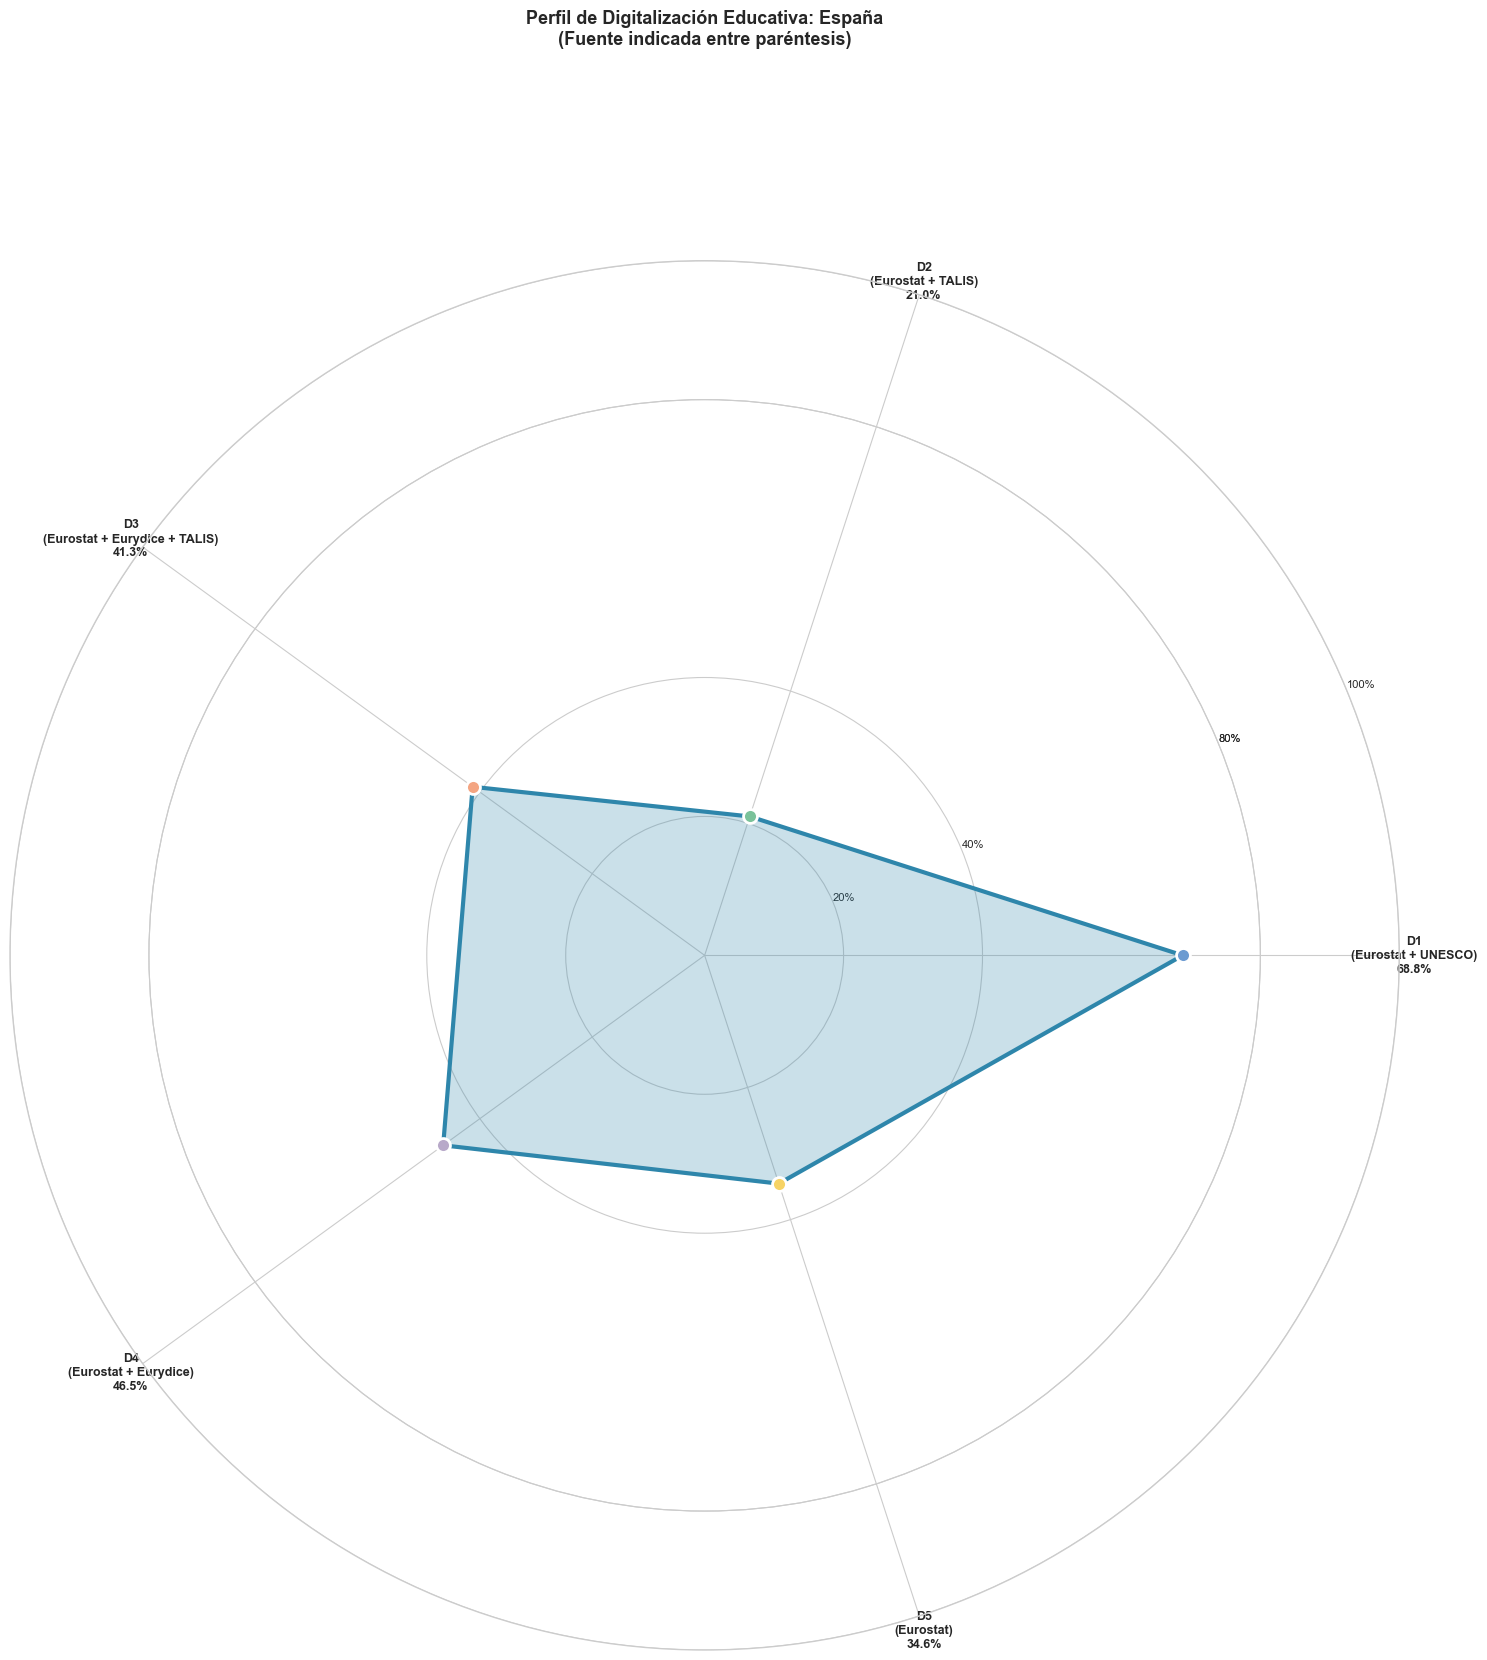

In [29]:
# ==============================================================================
# 6.3 GRÁFICO DE RADAR COMPARATIVO
# ==============================================================================
# ==============================================================================
# 5.5 RADAR INDIVIDUAL PARA UN PAÍS ESPECÍFICO (EJEMPLO: ESPAÑA)
# ==============================================================================

def crear_radar_pais(df, pais, df_fuentes):
    """
    Crea un gráfico de radar para un país específico con detalle de fuentes.
    """
    if pais not in df.index:
        print(f"⚠️ País '{pais}' no encontrado en los datos")
        return
    
    valores = df.loc[pais]
    fuentes = df_fuentes.loc[pais] if pais in df_fuentes.index else None
    
    dimensiones = valores.index.tolist()
    num_vars = len(dimensiones)
    
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    valores_list = valores.tolist()
    valores_list += valores_list[:1]
    valores_list = [v if pd.notna(v) else 0 for v in valores_list]
    
    fig, ax = plt.subplots(figsize=(15, 20), subplot_kw=dict(polar=True))
    
    # Colores por dimensión
    ax.plot(angles, valores_list, 'o-', linewidth=3, color='#2E86AB')
    ax.fill(angles, valores_list, alpha=0.25, color='#2E86AB')
    
    # Añadir puntos con colores de dimensión
    for i, (dim, val) in enumerate(zip(dimensiones, valores_list[:-1])):
        color_dim = COLORES_DIMENSIONES.get(dim, EU_PASTEL[0])
        ax.scatter(angles[i], val, s=100, color=color_dim, zorder=5, edgecolors='white', linewidth=2)
    
    # Etiquetas
    etiquetas = []
    for d in dimensiones:
        val = valores[d]
        fuente = fuentes[d] if fuentes is not None and d in fuentes else '?'
        etiquetas.append(f"{d}\n({fuente})\n{val:.1f}%")
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(etiquetas, fontsize=9, fontweight='bold')
    
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 80, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=8)
    
    ax.set_title(f'Perfil de Digitalización Educativa: {pais}\n(Fuente indicada entre paréntesis)', 
                 fontsize=13, fontweight='bold', y=1.15)
    
    plt.tight_layout()
    plt.show()

# Crear radar para España
crear_radar_pais(pivot_radar_filtrado, 'España', pivot_fuentes)

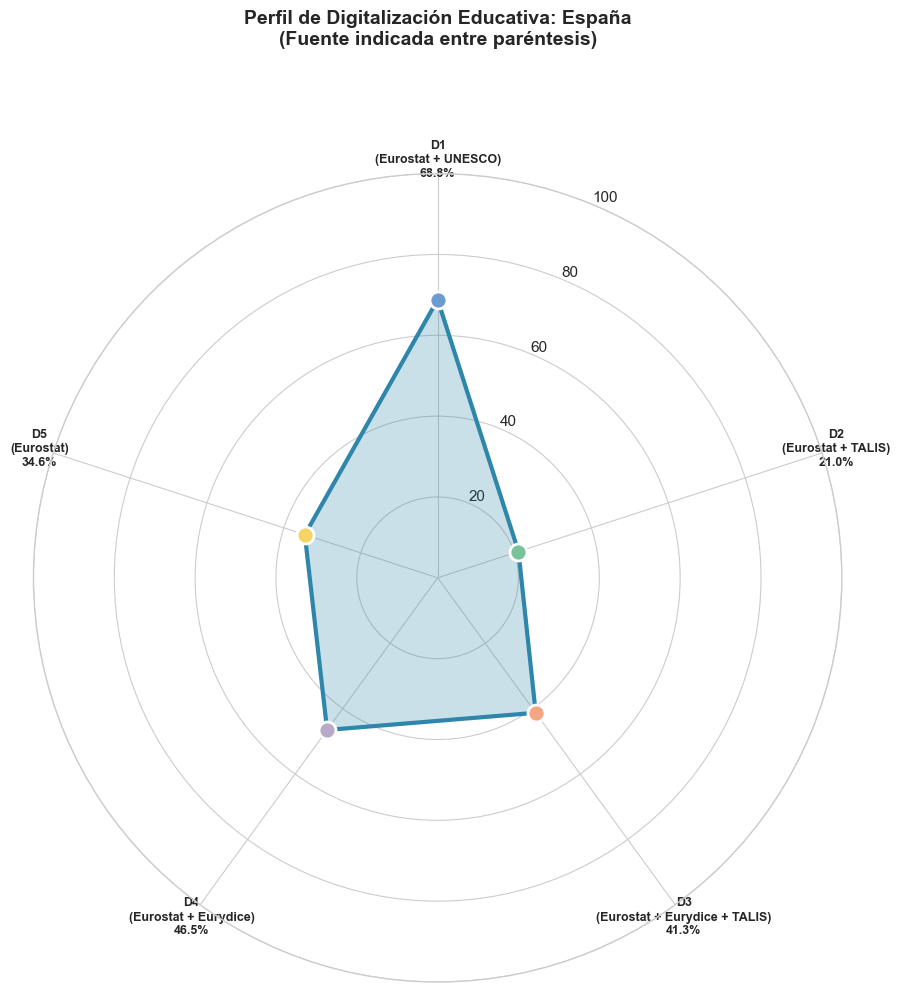

In [30]:
# ==============================================================================
# 6.4 RADAR INDIVIDUAL PARA ESPAÑA
# ==============================================================================

def crear_radar_individual(df, df_fuentes, pais):
    if pais not in df.index:
        print(f"⚠️ '{pais}' no encontrado")
        return
    
    valores = df.loc[pais]
    fuentes = df_fuentes.loc[pais] if pais in df_fuentes.index else None
    
    dimensiones = valores.index.tolist()
    num_vars = len(dimensiones)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    valores_list = [v if pd.notna(v) else 0 for v in valores.tolist()]
    valores_list += valores_list[:1]
    
    fig, ax = plt.subplots(figsize=(13, 10), subplot_kw=dict(polar=True))
    
    ax.plot(angles, valores_list, 'o-', linewidth=3, color='#2E86AB')
    ax.fill(angles, valores_list, alpha=0.25, color='#2E86AB')
    
    for i, (dim, val) in enumerate(zip(dimensiones, valores_list[:-1])):
        color = COLORES_DIMENSIONES.get(dim, EU_PASTEL[0])
        ax.scatter(angles[i], val, s=150, color=color, zorder=5, edgecolors='white', linewidth=2)
    
    etiquetas = []
    for d in dimensiones:
        val = valores[d] if pd.notna(valores[d]) else 0
        fuente = fuentes[d] if fuentes is not None and d in fuentes else '?'
        etiquetas.append(f"{d}\n({fuente})\n{val:.1f}%")
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(etiquetas, fontsize=9, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_title(f'Perfil de Digitalización Educativa: {pais}\n(Fuente indicada entre paréntesis)', 
                 fontsize=14, fontweight='bold', y=1.15)
    plt.tight_layout()
    plt.show()

crear_radar_individual(pivot_radar_filtrado, pivot_fuentes, 'España')

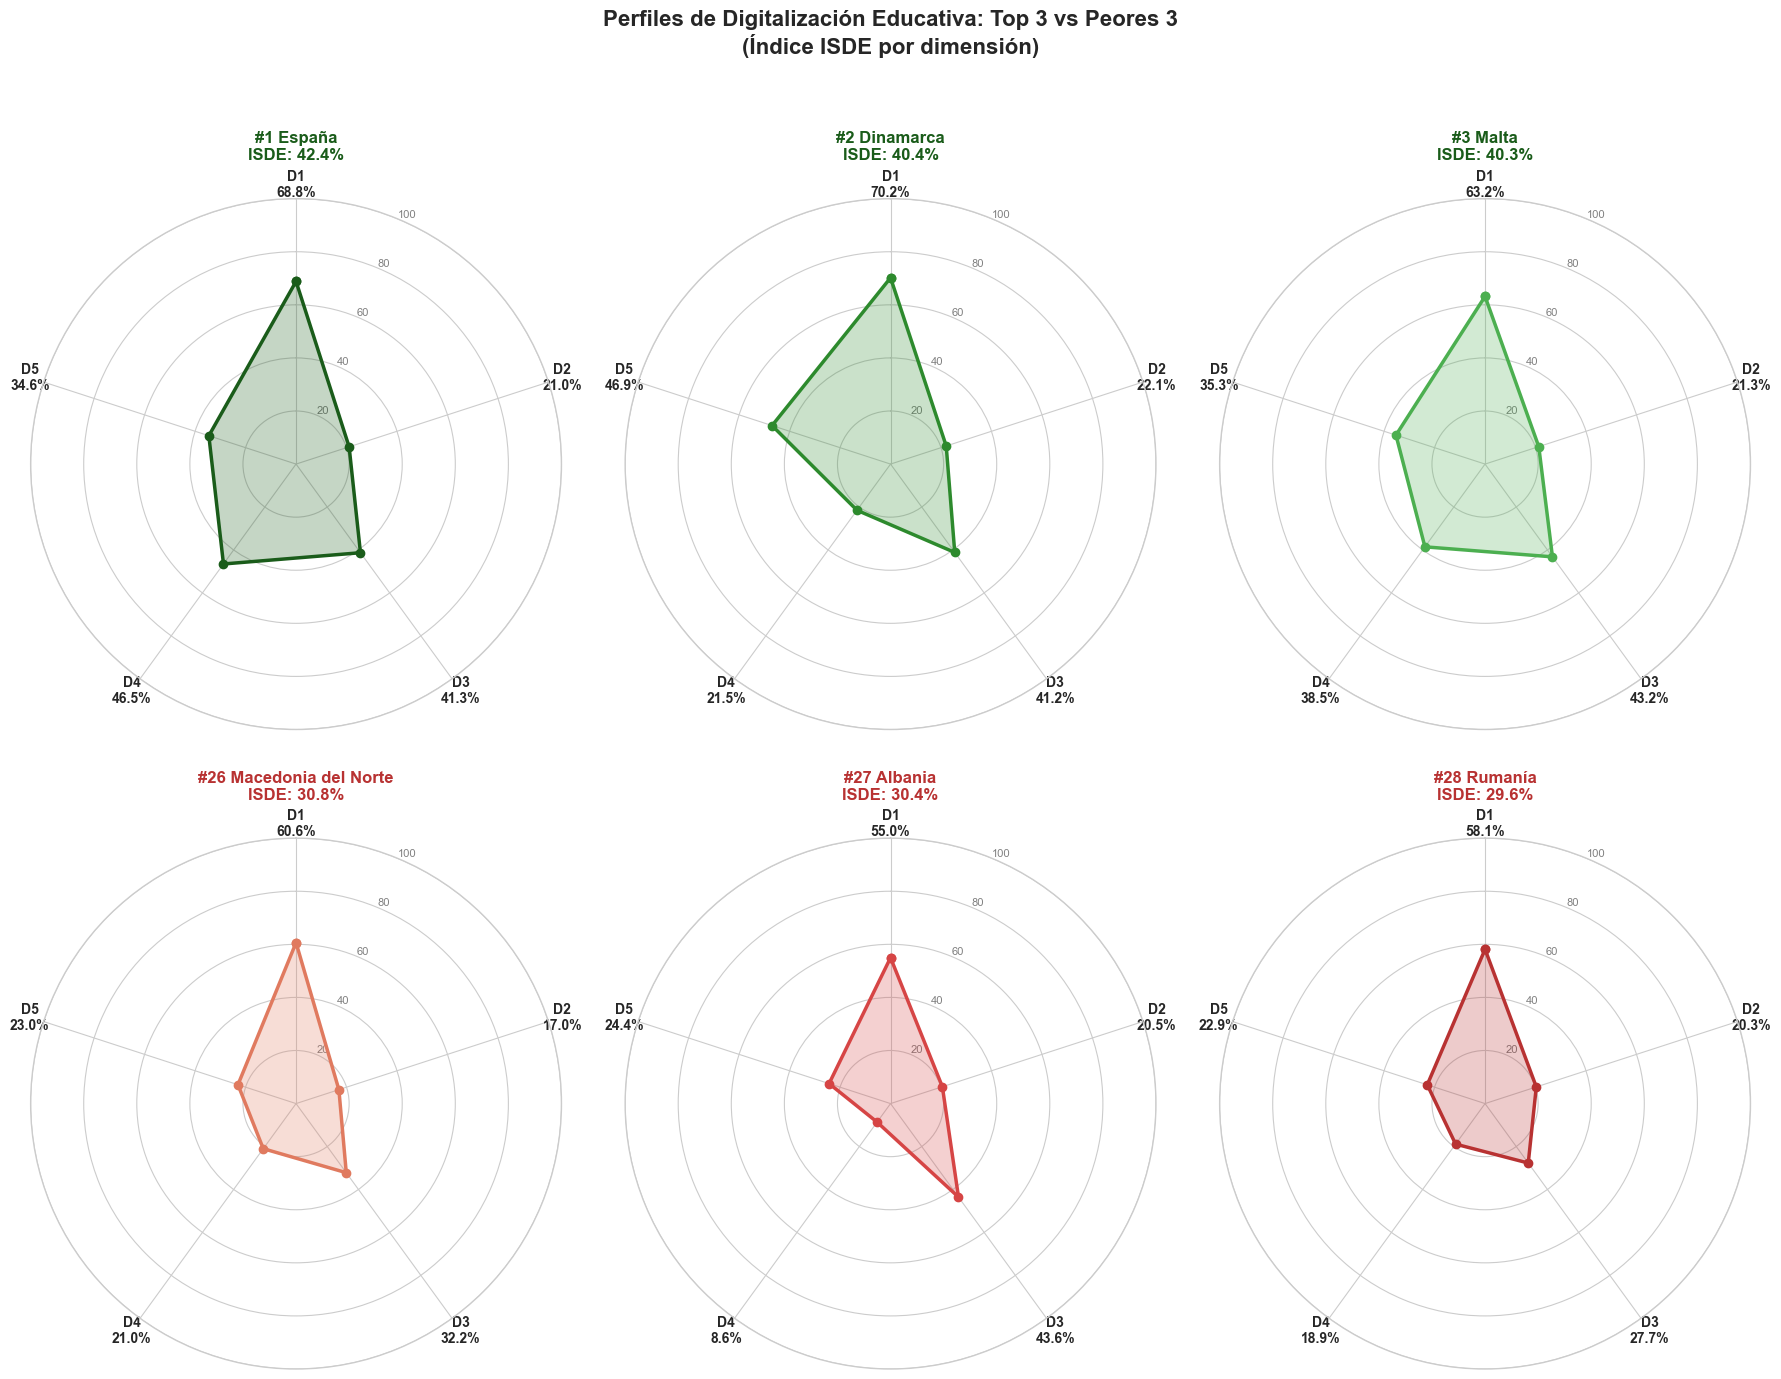

In [31]:
# ==============================================================================
# 6.X RADARES COMPARATIVOS: TOP 3 MEJORES Y PEORES PAÍSES
# ==============================================================================

from math import pi
import pandas as pd
import matplotlib.pyplot as plt

# OJO: NO HAGAS "import ranking"
# Si lo hiciste antes en el notebook, ejecuta esto para limpiar el nombre:
# try: del ranking
# except: pass


# -----------------------------
# 1) Construir ranking (DataFrame)
# -----------------------------
dimensiones = ['D1', 'D2', 'D3', 'D4', 'D5']

# Asegura que solo cogemos esas columnas (si faltara alguna, la crea como NaN)
df_ranking = pivot_radar_filtrado.copy()
for d in dimensiones:
    if d not in df_ranking.columns:
        df_ranking[d] = pd.NA
df_ranking = df_ranking[dimensiones]

# ISDE promedio (media de dimensiones disponibles, ignorando NaN)
df_ranking['ISDE_promedio'] = df_ranking.mean(axis=1, skipna=True)

# Ordenar: mejores arriba
df_ranking = df_ranking.sort_values('ISDE_promedio', ascending=False)

# Si quieres ver el ranking:
# display(df_ranking[['ISDE_promedio'] + dimensiones].head(10))


# -----------------------------
# 2) Top 3 y Bottom 3
# -----------------------------
n = min(3, len(df_ranking))  # por si hubiera menos de 3 países
top3 = df_ranking.head(n).index.tolist()
bottom3 = df_ranking.tail(n).index.tolist()
paises_radar = top3 + bottom3


# -----------------------------
# 3) Plot radares (2x3)
# -----------------------------
num_dims = len(dimensiones)
angulos = [i / float(num_dims) * 2 * pi for i in range(num_dims)]
angulos += angulos[:1]  # cerrar polígono

fig, axes = plt.subplots(2, 3, figsize=(18, 14), subplot_kw=dict(polar=True))
axes = axes.flatten()

# Colores: verdes para top 3, rojos/coral para bottom 3
colores_top = ['#1a5c1a', '#2d8a2d', '#4CAF50']
colores_bottom = ['#E07A5F', '#D64545', '#B83232']
colores = (colores_top[:n] + colores_bottom[:n])

# Si quieres añadir fuentes en las etiquetas, ponlo en True
MOSTRAR_FUENTES = False

for idx, pais in enumerate(paises_radar):
    ax = axes[idx]

    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    # valores del país (D1..D5)
    serie = df_ranking.loc[pais, dimensiones]
    valores = [v if pd.notna(v) else 0 for v in serie.tolist()]
    valores += valores[:1]

    # dibujar radar
    ax.plot(angulos, valores, 'o-', linewidth=2.5, color=colores[idx], markersize=6)
    ax.fill(angulos, valores, alpha=0.25, color=colores[idx])

    # etiquetas (dim + valor, opcionalmente fuente)
    etiquetas = []
    for d in dimensiones:
        val = df_ranking.loc[pais, d]
        val_txt = f"{val:.1f}%" if pd.notna(val) else "N/A"

        if MOSTRAR_FUENTES and (pais in pivot_fuentes.index) and (d in pivot_fuentes.columns):
            fuente = pivot_fuentes.loc[pais, d]
            etiquetas.append(f"{d}\n({fuente})\n{val_txt}")
        else:
            etiquetas.append(f"{d}\n{val_txt}")

    ax.set_xticks(angulos[:-1])
    ax.set_xticklabels(etiquetas, fontsize=10, fontweight='bold')

    # ejes radiales
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=8, color='gray')

    # título con posición en ranking e ISDE promedio
    isde_val = df_ranking.loc[pais, 'ISDE_promedio']
    pos = list(df_ranking.index).index(pais) + 1
    ax.set_title(
        f'#{pos} {pais}\nISDE: {isde_val:.1f}%',
        fontsize=12, fontweight='bold', pad=28,
        color='#1a5c1a' if idx < n else '#B83232'
    )

# Si hay menos de 6 países (ej: dataset pequeño), apaga los axes sobrantes
for j in range(len(paises_radar), len(axes)):
    axes[j].axis('off')

plt.suptitle(
    'Perfiles de Digitalización Educativa: Top 3 vs Peores 3\n(Índice ISDE por dimensión)',
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

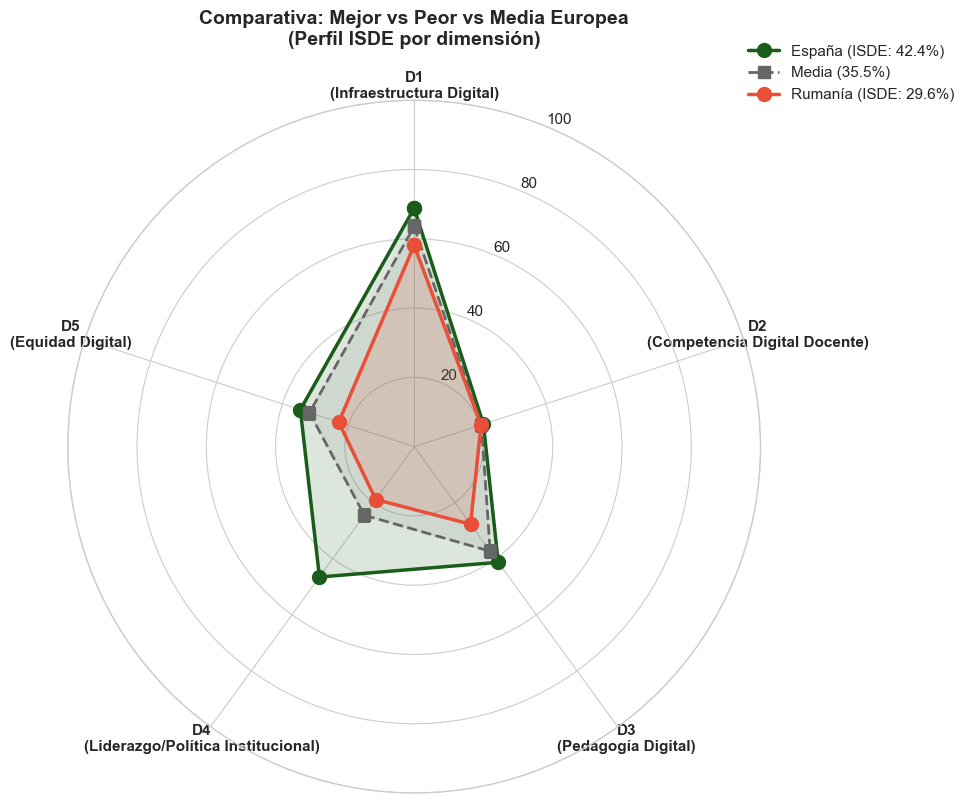

In [32]:
# Radar comparativo superpuesto: Top 1 vs Bottom 1 vs Media
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Media de todos los países
media_valores = df_ranking[dimensiones].mean().fillna(0).values.tolist()
media_valores += media_valores[:1]

# Top 1
top1_valores = df_ranking.loc[top3[0], dimensiones].fillna(0).values.tolist()
top1_valores += top1_valores[:1]

# Bottom 1
bottom1_valores = df_ranking.loc[bottom3[-1], dimensiones].fillna(0).values.tolist()
bottom1_valores += bottom1_valores[:1]

angulos = [n / float(num_dims) * 2 * pi for n in range(num_dims)]
angulos += angulos[:1]

# Dibujar las 3 líneas
ax.plot(angulos, top1_valores, 'o-', linewidth=2.5, color='#1a5c1a', label=f'{top3[0]} (ISDE: {df_ranking.loc[top3[0], "ISDE_promedio"]:.1f}%)', markersize=10)
ax.fill(angulos, top1_valores, alpha=0.15, color='#1a5c1a')

ax.plot(angulos, media_valores, 's--', linewidth=2, color='#666666', label=f'Media ({df_ranking["ISDE_promedio"].mean():.1f}%)', markersize=8)
ax.fill(angulos, media_valores, alpha=0.1, color='#666666')

ax.plot(angulos, bottom1_valores, 'o-', linewidth=2.5, color='#E94F37', label=f'{bottom3[-1]} (ISDE: {df_ranking.loc[bottom3[-1], "ISDE_promedio"]:.1f}%)', markersize=10)
ax.fill(angulos, bottom1_valores, alpha=0.15, color='#E94F37')

# Etiquetas
etiquetas_dims = [f'{dim}\n({NOMBRES_DIMENSIONES.get(dim, dim)})' for dim in dimensiones]
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(etiquetas_dims, fontsize=11, fontweight='bold')

ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

ax.set_title('Comparativa: Mejor vs Peor vs Media Europea\n(Perfil ISDE por dimensión)', 
             fontsize=14, fontweight='bold', pad=40)
ax.set_theta_offset(pi/2)
ax.set_theta_direction(-1)

plt.tight_layout()
plt.show()

In [33]:
# ==============================================================================
# 6.5 TABLA DE FUENTES POR DIMENSIÓN Y PAÍS
# ==============================================================================

print("\n📋 FUENTES UTILIZADAS PARA CADA DIMENSIÓN Y PAÍS:")
print("="*70)
print("\nNota: Cuando hay múltiples fuentes, se han PROMEDIADO los valores.")
print("\n" + pivot_fuentes.fillna('-').to_string())


📋 FUENTES UTILIZADAS PARA CADA DIMENSIÓN Y PAÍS:

Nota: Cuando hay múltiples fuentes, se han PROMEDIADO los valores.

Dimension                           D1                D2                           D3                   D4        D5
Nombre_Pais                                                                                                         
Albania              Eurostat + UNESCO  Eurostat + TALIS  Eurostat + Eurydice + TALIS  Eurostat + Eurydice  Eurostat
Austria              Eurostat + UNESCO  Eurostat + TALIS  Eurostat + Eurydice + TALIS  Eurostat + Eurydice  Eurostat
Bulgaria             Eurostat + UNESCO  Eurostat + TALIS  Eurostat + Eurydice + TALIS  Eurostat + Eurydice  Eurostat
Chequia              Eurostat + UNESCO  Eurostat + TALIS  Eurostat + Eurydice + TALIS  Eurostat + Eurydice  Eurostat
Chipre               Eurostat + UNESCO  Eurostat + TALIS  Eurostat + Eurydice + TALIS  Eurostat + Eurydice  Eurostat
Croacia              Eurostat + UNESCO  Eurostat + TALIS  Euro

---
# 7. Resumen y Conclusiones
---

In [34]:
# ==============================================================================
# 7.1 RESUMEN FINAL DEL EDA v8
# ==============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        RESUMEN DEL EDA v8                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASETS ANALIZADOS:
""")

print(f"   • TALIS 2024:      {len(talis):,} registros | Dimensiones: D2, D3")
print(f"   • Eurydice 2023:   {len(eurydice):,} registros | Dimensiones: D3, D4")
print(f"   • Eurostat/DESI:   {len(eurostat):,} registros | Dimensiones: D1-D5")
print(f"   • UNESCO UIS:      {len(unesco):,} registros | Dimensiones: D1")

print(f"""
\n🌍 PAÍSES COMUNES A LOS 4 DATASETS: {len(PAISES_COMUNES_ISO3)}
""")
for iso3 in sorted(PAISES_COMUNES_ISO3):
    print(f"   • {obtener_nombre_pais(iso3)} ({iso3})")

print("""
\n✅ CAMBIOS IMPLEMENTADOS EN v8:

   ✓ Rutas corregidas a archivos *_DIMENSIONES.xlsx
   ✓ Eurostat/DESI incluido (se había omitido en v7)
   ✓ Filtrado por países presentes en los 4 datasets
   ✓ UNESCO 5.3: Diagrama de barras con 3 países de menor % D1 por año
   ✓ Eurydice 3.3: Eje X ordenado de mayor a menor nº políticas
   ✓ Gráfico de radar con valores promediados de todas las fuentes

📈 PRÓXIMOS PASOS:

   • Normalización avanzada de variables (z-score, min-max)
   • Análisis de Componentes Principales (PCA)
   • Construcción del Índice Sintético ISDE
   • Clustering de países por perfil de digitalización
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                        RESUMEN DEL EDA v8                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 DATASETS ANALIZADOS:

   • TALIS 2024:      3,465 registros | Dimensiones: D2, D3
   • Eurydice 2023:   952 registros | Dimensiones: D3, D4
   • Eurostat/DESI:   1,924,459 registros | Dimensiones: D1-D5
   • UNESCO UIS:      444 registros | Dimensiones: D1


🌍 PAÍSES COMUNES A LOS 4 DATASETS: 28

   • Albania (ALB)
   • Austria (AUT)
   • Bulgaria (BGR)
   • Chipre (CYP)
   • Chequia (CZE)
   • Dinamarca (DNK)
   • España (ESP)
   • Estonia (EST)
   • Finlandia (FIN)
   • Francia (FRA)
   • Croacia (HRV)
   • Hungría (HUN)
   • Italia (ITA)
   • Lituania (LTU)
   • Letonia (LVA)
   • Macedonia del Norte (MKD)
   • Malta (MLT)
   • Montenegro (MNE)
   • Países Bajos (NLD)
   • Noruega (NOR)
   • Polonia (POL)
   • Portugal (PRT)
   • Rumanía (R